In [1]:
import os
import cv2
import torch
import helper
import time
import random
from tqdm import tqdm
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
import torchvision
import matplotlib.pyplot as plt

In [2]:
# define the path to the images and masks dataset
image_dataset_path = "dataset\\PPL"
mask_dataset_path = "dataset\\SE"

# define the test split
test_split = 0.10

# determine the device to be used for training and evaluation
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.backends.cudnn.benchmark = True

#initialize learning rate, number of epochs to train for, and the batch size
init_lr = 1e-4
num_epochs = 500
batch_size = 5

# define the input image dimensions
input_image_width = 400
input_image_height = 400

# define the path to the base output directory
base_output = "output"

# define the path to the output serialized model, model training plot, and testing image paths
model_path = os.path.join(base_output, "unet_model.pth")
plot_path = os.path.sep.join([base_output, "plot.png"])
test_paths = os.path.sep.join([base_output, "test_paths.txt"])

In [3]:
# load the image and mask filepaths in a sorted manner
imagePaths = os.listdir(image_dataset_path)
maskPaths = os.listdir(mask_dataset_path)
imageprefix = image_dataset_path + "\\"
maskprefix = mask_dataset_path + "\\"
imagePaths = [imageprefix + x for x in imagePaths]
maskPaths = [maskprefix + x for x in maskPaths]
# partition the data into training and testing splits using 85% of the data for training and the remaining 15% for testing
split = train_test_split(imagePaths, maskPaths, test_size=test_split, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]
# write the testing image paths to disk so that we can use then when evaluating/testing our model
print("[INFO] saving testing image paths...")
f = open(test_paths, "w")
f.write("\n".join(testImages))
f.close()

[INFO] saving testing image paths...


In [4]:
class SegmentationDataset(Dataset):
    def __init__(self, imagePaths, maskPaths, transforms):
        # store the image and mask filepaths, and augmentation transforms
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.transforms = transforms
    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.imagePaths)
    def __getitem__(self, idx):
        img_path = self.imagePaths[idx]
        mask_path = self.maskPaths[idx]
        img_1 = np.array(Image.open(img_path).convert("RGB"), dtype = np.float32) / 255.
        img_2_path = img_path.replace("PPL", "XPL")
        img_2 = np.array(Image.open(img_2_path).convert("RGB"), dtype = np.float32) / 255.
        image = np.concatenate((img_1, img_2), axis=-1)
        mask = np.array(Image.open(mask_path).convert("L"), dtype = np.float32) / 255.
        if self.transforms is not None:
            seed = np.random.randint(2147483647) 
            random.seed(seed) 
            torch.manual_seed(seed) 
            image = self.transforms(image)
            random.seed(seed) 
            torch.manual_seed(seed)
            mask = self.transforms(mask)
        return (image, mask)

In [5]:
# define transformations
transforms_ = transforms.Compose([transforms.ToTensor(), 
                                       transforms.RandomRotation(180),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip()]) 

# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks, transforms=transforms_)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks, transforms=transforms_)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True, batch_size=batch_size, pin_memory = True if device == "cuda" else False)
testLoader = DataLoader(testDS, shuffle=False, batch_size=batch_size, pin_memory= True if device == "cuda" else False)

[INFO] found 199 examples in the training set...
[INFO] found 23 examples in the test set...


In [6]:
# Run this to test your data loader
(images, masks) = next(iter(trainLoader))

In [7]:
print(f'x = shape: {images.shape}; type: {images.dtype}')
print(f'y = shape: {masks.shape}; type: {masks.dtype}')
print(f'x = min: {images.min()}; max: {images.max()}')
print(f'y = min: {masks.min()}; max: {masks.max()}')

x = shape: torch.Size([5, 6, 400, 400]); type: torch.float32
y = shape: torch.Size([5, 1, 400, 400]); type: torch.float32
x = min: 0.0; max: 1.0
y = min: 0.0; max: 0.9647058844566345


<AxesSubplot:>

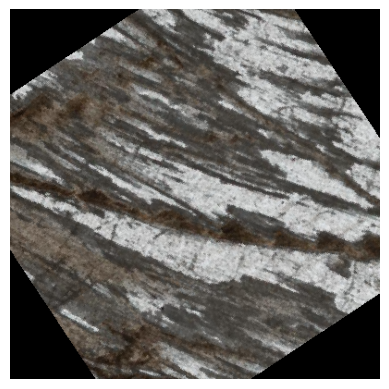

In [8]:
helper.imshow(images[0][0:3,:,:], normalize=False)

<AxesSubplot:>

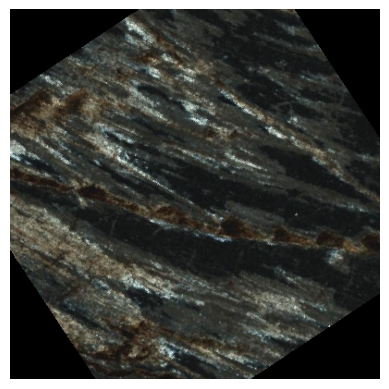

In [9]:
helper.imshow(images[0][3:6,:,:], normalize=False)

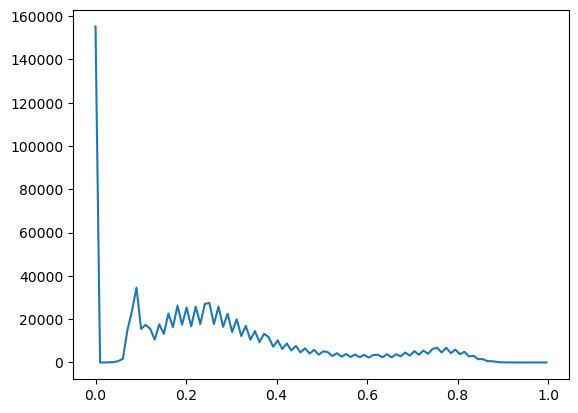

In [10]:
hist = images[0].histc()
images_min = images[0].min().item()
images_max = images[0].max().item()
plt.plot(torch.linspace(images_min, images_max, len(hist)), hist)
plt.show()

<AxesSubplot:>

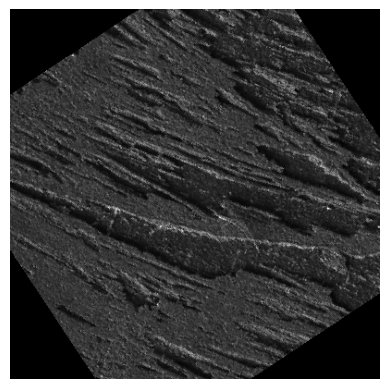

In [11]:
helper.imshow(masks[0], normalize=False, cmap='gray')

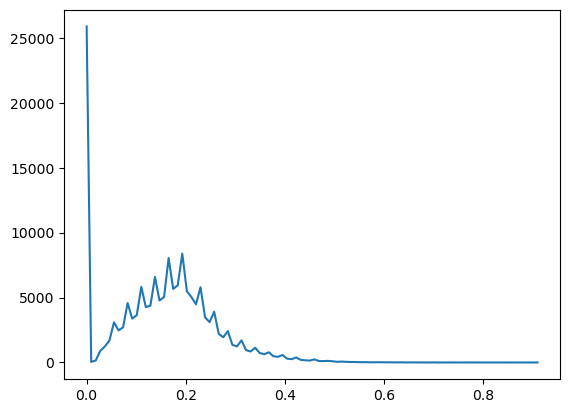

In [12]:
hist = masks[0].histc()
masks_min = masks[0].min().item()
masks_max = masks[0].max().item()
plt.plot(torch.linspace(masks_min, masks_max, len(hist)), hist)
plt.show()

In [13]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(
        self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # make sure the input is dividable by 16
        
        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
            
        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))
            
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
    
    def forward(self, x):
        skip_connections = []
        
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
            
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            
            # to solve the problem of input not dividable by 16
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])
                
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
            
        return self.final_conv(x)

In [14]:
# initialize our UNet model
unet = UNet(in_channels=6, out_channels=1).to(device)
# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss() # change to cross entropy loss for multi class
opt = Adam(unet.parameters(), lr=init_lr)
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // batch_size
testSteps = len(testDS) // batch_size
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [15]:
pred = unet(images.to(device))

In [16]:
loss = lossFunc(pred, masks.to(device))
print(loss)

tensor(0.7777, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [17]:
new_pred = pred.cpu()

In [18]:
new_pred = torch.sigmoid(new_pred)

<AxesSubplot:>

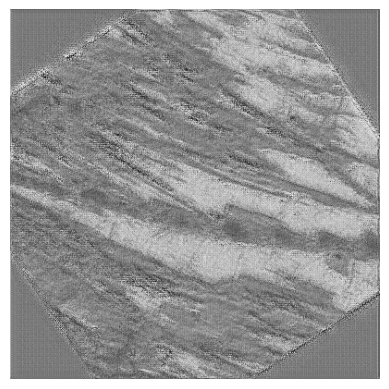

In [19]:
helper.imshow(new_pred[0].detach(), normalize=False, cmap='gray')

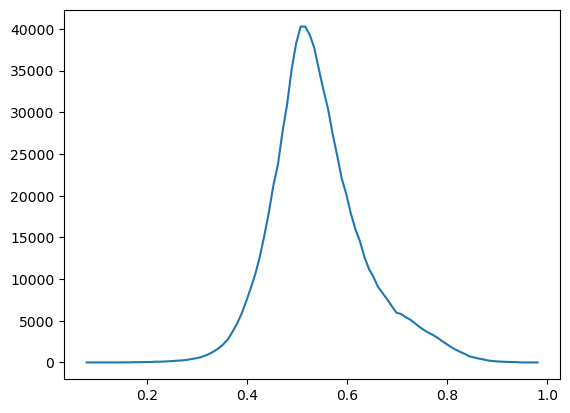

In [20]:
hist = new_pred.histc()
new_pred_min = new_pred.min().item()
new_pred_max = new_pred.max().item()
plt.plot(torch.linspace(new_pred_min, new_pred_max, len(hist)), hist)
plt.show()

[INFO] training the network...


  0%|▏                                                                               | 1/500 [00:42<5:55:45, 42.78s/it]

[INFO] EPOCH: 1/500
Train loss: 0.630170, Test loss: 0.8085


  0%|▎                                                                               | 2/500 [01:02<4:01:15, 29.07s/it]

[INFO] EPOCH: 2/500
Train loss: 0.525576, Test loss: 0.6660


  1%|▍                                                                               | 3/500 [01:21<3:22:34, 24.46s/it]

[INFO] EPOCH: 3/500
Train loss: 0.504114, Test loss: 0.6194


  1%|▋                                                                               | 4/500 [01:40<3:05:07, 22.39s/it]

[INFO] EPOCH: 4/500
Train loss: 0.495239, Test loss: 0.6313


  1%|▊                                                                               | 5/500 [02:00<2:57:01, 21.46s/it]

[INFO] EPOCH: 5/500
Train loss: 0.491730, Test loss: 0.5982


  1%|▉                                                                               | 6/500 [02:20<2:52:14, 20.92s/it]

[INFO] EPOCH: 6/500
Train loss: 0.482407, Test loss: 0.6010


  1%|█                                                                               | 7/500 [02:39<2:49:00, 20.57s/it]

[INFO] EPOCH: 7/500
Train loss: 0.482669, Test loss: 0.5873


  2%|█▎                                                                              | 8/500 [02:59<2:47:01, 20.37s/it]

[INFO] EPOCH: 8/500
Train loss: 0.477558, Test loss: 0.5818


  2%|█▍                                                                              | 9/500 [03:20<2:46:10, 20.31s/it]

[INFO] EPOCH: 9/500
Train loss: 0.474207, Test loss: 0.5866


  2%|█▌                                                                             | 10/500 [03:39<2:44:43, 20.17s/it]

[INFO] EPOCH: 10/500
Train loss: 0.472787, Test loss: 0.5957


  2%|█▋                                                                             | 11/500 [03:59<2:43:49, 20.10s/it]

[INFO] EPOCH: 11/500
Train loss: 0.468940, Test loss: 0.5805


  2%|█▉                                                                             | 12/500 [04:19<2:42:54, 20.03s/it]

[INFO] EPOCH: 12/500
Train loss: 0.469536, Test loss: 0.5808


  3%|██                                                                             | 13/500 [04:39<2:41:58, 19.96s/it]

[INFO] EPOCH: 13/500
Train loss: 0.470281, Test loss: 0.5852


  3%|██▏                                                                            | 14/500 [04:59<2:41:22, 19.92s/it]

[INFO] EPOCH: 14/500
Train loss: 0.468421, Test loss: 0.5680


  3%|██▎                                                                            | 15/500 [05:20<2:42:49, 20.14s/it]

[INFO] EPOCH: 15/500
Train loss: 0.466866, Test loss: 0.5796


  3%|██▌                                                                            | 16/500 [05:40<2:42:20, 20.12s/it]

[INFO] EPOCH: 16/500
Train loss: 0.465325, Test loss: 0.5880


  3%|██▋                                                                            | 17/500 [06:00<2:41:34, 20.07s/it]

[INFO] EPOCH: 17/500
Train loss: 0.465993, Test loss: 0.5643


  4%|██▊                                                                            | 18/500 [06:20<2:43:14, 20.32s/it]

[INFO] EPOCH: 18/500
Train loss: 0.466564, Test loss: 0.5663


  4%|███                                                                            | 19/500 [06:40<2:41:58, 20.20s/it]

[INFO] EPOCH: 19/500
Train loss: 0.465425, Test loss: 0.5823


  4%|███▏                                                                           | 20/500 [07:00<2:40:45, 20.10s/it]

[INFO] EPOCH: 20/500
Train loss: 0.468570, Test loss: 0.5747


  4%|███▎                                                                           | 21/500 [07:21<2:41:33, 20.24s/it]

[INFO] EPOCH: 21/500
Train loss: 0.466222, Test loss: 0.5629


  4%|███▍                                                                           | 22/500 [07:41<2:40:22, 20.13s/it]

[INFO] EPOCH: 22/500
Train loss: 0.463513, Test loss: 0.5725


  5%|███▋                                                                           | 23/500 [08:01<2:39:27, 20.06s/it]

[INFO] EPOCH: 23/500
Train loss: 0.464658, Test loss: 0.5727


  5%|███▊                                                                           | 24/500 [08:20<2:38:27, 19.97s/it]

[INFO] EPOCH: 24/500
Train loss: 0.467330, Test loss: 0.5791


  5%|███▉                                                                           | 25/500 [08:40<2:37:45, 19.93s/it]

[INFO] EPOCH: 25/500
Train loss: 0.462723, Test loss: 0.5843


  5%|████                                                                           | 26/500 [09:00<2:37:08, 19.89s/it]

[INFO] EPOCH: 26/500
Train loss: 0.465409, Test loss: 0.5764


  5%|████▎                                                                          | 27/500 [09:20<2:37:51, 20.02s/it]

[INFO] EPOCH: 27/500
Train loss: 0.466119, Test loss: 0.5784


  6%|████▍                                                                          | 28/500 [09:40<2:37:11, 19.98s/it]

[INFO] EPOCH: 28/500
Train loss: 0.463995, Test loss: 0.5655


  6%|████▌                                                                          | 29/500 [10:00<2:36:31, 19.94s/it]

[INFO] EPOCH: 29/500
Train loss: 0.463803, Test loss: 0.5700


  6%|████▋                                                                          | 30/500 [10:20<2:35:55, 19.90s/it]

[INFO] EPOCH: 30/500
Train loss: 0.464873, Test loss: 0.5626


  6%|████▉                                                                          | 31/500 [10:40<2:35:17, 19.87s/it]

[INFO] EPOCH: 31/500
Train loss: 0.464241, Test loss: 0.5811


  6%|█████                                                                          | 32/500 [10:59<2:34:49, 19.85s/it]

[INFO] EPOCH: 32/500
Train loss: 0.465517, Test loss: 0.5683


  7%|█████▏                                                                         | 33/500 [11:19<2:34:20, 19.83s/it]

[INFO] EPOCH: 33/500
Train loss: 0.465650, Test loss: 0.5809


  7%|█████▎                                                                         | 34/500 [11:40<2:35:09, 19.98s/it]

[INFO] EPOCH: 34/500
Train loss: 0.462126, Test loss: 0.5662


  7%|█████▌                                                                         | 35/500 [11:59<2:34:23, 19.92s/it]

[INFO] EPOCH: 35/500
Train loss: 0.465609, Test loss: 0.5774


  7%|█████▋                                                                         | 36/500 [12:19<2:33:58, 19.91s/it]

[INFO] EPOCH: 36/500
Train loss: 0.461165, Test loss: 0.5831


  7%|█████▊                                                                         | 37/500 [12:39<2:33:28, 19.89s/it]

[INFO] EPOCH: 37/500
Train loss: 0.462355, Test loss: 0.5753


  8%|██████                                                                         | 38/500 [12:59<2:32:56, 19.86s/it]

[INFO] EPOCH: 38/500
Train loss: 0.463604, Test loss: 0.5840


  8%|██████▏                                                                        | 39/500 [13:19<2:32:46, 19.88s/it]

[INFO] EPOCH: 39/500
Train loss: 0.462357, Test loss: 0.5806


  8%|██████▎                                                                        | 40/500 [13:39<2:33:44, 20.05s/it]

[INFO] EPOCH: 40/500
Train loss: 0.464085, Test loss: 0.5715


  8%|██████▍                                                                        | 41/500 [13:59<2:32:57, 19.99s/it]

[INFO] EPOCH: 41/500
Train loss: 0.462493, Test loss: 0.5726


  8%|██████▋                                                                        | 42/500 [14:19<2:32:07, 19.93s/it]

[INFO] EPOCH: 42/500
Train loss: 0.463517, Test loss: 0.5707


  9%|██████▊                                                                        | 43/500 [14:39<2:31:35, 19.90s/it]

[INFO] EPOCH: 43/500
Train loss: 0.462043, Test loss: 0.5842


  9%|██████▉                                                                        | 44/500 [14:59<2:31:10, 19.89s/it]

[INFO] EPOCH: 44/500
Train loss: 0.459539, Test loss: 0.5850


  9%|███████                                                                        | 45/500 [15:18<2:30:43, 19.88s/it]

[INFO] EPOCH: 45/500
Train loss: 0.461770, Test loss: 0.5732


  9%|███████▎                                                                       | 46/500 [15:39<2:31:58, 20.09s/it]

[INFO] EPOCH: 46/500
Train loss: 0.461813, Test loss: 0.5700


  9%|███████▍                                                                       | 47/500 [15:59<2:31:22, 20.05s/it]

[INFO] EPOCH: 47/500
Train loss: 0.459424, Test loss: 0.5693


 10%|███████▌                                                                       | 48/500 [16:19<2:30:46, 20.01s/it]

[INFO] EPOCH: 48/500
Train loss: 0.461222, Test loss: 0.5675


 10%|███████▋                                                                       | 49/500 [16:39<2:30:10, 19.98s/it]

[INFO] EPOCH: 49/500
Train loss: 0.464754, Test loss: 0.5662


 10%|███████▉                                                                       | 50/500 [16:59<2:29:35, 19.95s/it]

[INFO] EPOCH: 50/500
Train loss: 0.463732, Test loss: 0.5580


 10%|████████                                                                       | 51/500 [17:18<2:28:52, 19.89s/it]

[INFO] EPOCH: 51/500
Train loss: 0.465460, Test loss: 0.5547


 10%|████████▏                                                                      | 52/500 [17:39<2:30:01, 20.09s/it]

[INFO] EPOCH: 52/500
Train loss: 0.464159, Test loss: 0.5760


 11%|████████▎                                                                      | 53/500 [17:59<2:29:07, 20.02s/it]

[INFO] EPOCH: 53/500
Train loss: 0.466615, Test loss: 0.5610


 11%|████████▌                                                                      | 54/500 [18:19<2:28:06, 19.92s/it]

[INFO] EPOCH: 54/500
Train loss: 0.465061, Test loss: 0.5873


 11%|████████▋                                                                      | 55/500 [18:38<2:27:28, 19.88s/it]

[INFO] EPOCH: 55/500
Train loss: 0.464861, Test loss: 0.5685


 11%|████████▊                                                                      | 56/500 [18:58<2:27:06, 19.88s/it]

[INFO] EPOCH: 56/500
Train loss: 0.460501, Test loss: 0.5713


 11%|█████████                                                                      | 57/500 [19:18<2:26:37, 19.86s/it]

[INFO] EPOCH: 57/500
Train loss: 0.462660, Test loss: 0.5623


 12%|█████████▏                                                                     | 58/500 [19:38<2:27:35, 20.03s/it]

[INFO] EPOCH: 58/500
Train loss: 0.465022, Test loss: 0.5657


 12%|█████████▎                                                                     | 59/500 [19:58<2:26:53, 19.98s/it]

[INFO] EPOCH: 59/500
Train loss: 0.462821, Test loss: 0.5762


 12%|█████████▍                                                                     | 60/500 [20:18<2:26:11, 19.93s/it]

[INFO] EPOCH: 60/500
Train loss: 0.462242, Test loss: 0.5713


 12%|█████████▋                                                                     | 61/500 [20:38<2:25:30, 19.89s/it]

[INFO] EPOCH: 61/500
Train loss: 0.461765, Test loss: 0.5864


 12%|█████████▊                                                                     | 62/500 [20:58<2:25:14, 19.90s/it]

[INFO] EPOCH: 62/500
Train loss: 0.463245, Test loss: 0.5625


 13%|█████████▉                                                                     | 63/500 [21:18<2:24:38, 19.86s/it]

[INFO] EPOCH: 63/500
Train loss: 0.461669, Test loss: 0.5753


 13%|██████████                                                                     | 64/500 [21:39<2:27:57, 20.36s/it]

[INFO] EPOCH: 64/500
Train loss: 0.461014, Test loss: 0.5745


 13%|██████████▎                                                                    | 65/500 [21:59<2:26:26, 20.20s/it]

[INFO] EPOCH: 65/500
Train loss: 0.460974, Test loss: 0.5739


 13%|██████████▍                                                                    | 66/500 [22:19<2:25:22, 20.10s/it]

[INFO] EPOCH: 66/500
Train loss: 0.462076, Test loss: 0.5628


 13%|██████████▌                                                                    | 67/500 [22:39<2:24:30, 20.03s/it]

[INFO] EPOCH: 67/500
Train loss: 0.462301, Test loss: 0.5778


 14%|██████████▋                                                                    | 68/500 [22:59<2:23:57, 19.99s/it]

[INFO] EPOCH: 68/500
Train loss: 0.460284, Test loss: 0.5629


 14%|██████████▉                                                                    | 69/500 [23:18<2:23:11, 19.93s/it]

[INFO] EPOCH: 69/500
Train loss: 0.463036, Test loss: 0.5712


 14%|███████████                                                                    | 70/500 [23:39<2:24:46, 20.20s/it]

[INFO] EPOCH: 70/500
Train loss: 0.461141, Test loss: 0.5695


 14%|███████████▏                                                                   | 71/500 [23:59<2:23:33, 20.08s/it]

[INFO] EPOCH: 71/500
Train loss: 0.462416, Test loss: 0.5723


 14%|███████████▍                                                                   | 72/500 [24:19<2:22:46, 20.02s/it]

[INFO] EPOCH: 72/500
Train loss: 0.459009, Test loss: 0.5699


 15%|███████████▌                                                                   | 73/500 [24:39<2:22:00, 19.95s/it]

[INFO] EPOCH: 73/500
Train loss: 0.462518, Test loss: 0.5784


 15%|███████████▋                                                                   | 74/500 [24:58<2:21:19, 19.90s/it]

[INFO] EPOCH: 74/500
Train loss: 0.462619, Test loss: 0.5767


 15%|███████████▊                                                                   | 75/500 [25:18<2:20:51, 19.89s/it]

[INFO] EPOCH: 75/500
Train loss: 0.464213, Test loss: 0.5739


 15%|████████████                                                                   | 76/500 [25:40<2:25:18, 20.56s/it]

[INFO] EPOCH: 76/500
Train loss: 0.463715, Test loss: 0.5649


 15%|████████████▏                                                                  | 77/500 [26:00<2:23:29, 20.35s/it]

[INFO] EPOCH: 77/500
Train loss: 0.459630, Test loss: 0.5598


 16%|████████████▎                                                                  | 78/500 [26:20<2:22:04, 20.20s/it]

[INFO] EPOCH: 78/500
Train loss: 0.463821, Test loss: 0.5775


 16%|████████████▍                                                                  | 79/500 [26:40<2:21:02, 20.10s/it]

[INFO] EPOCH: 79/500
Train loss: 0.460706, Test loss: 0.5626


 16%|████████████▋                                                                  | 80/500 [27:00<2:19:59, 20.00s/it]

[INFO] EPOCH: 80/500
Train loss: 0.463826, Test loss: 0.5742


 16%|████████████▊                                                                  | 81/500 [27:20<2:19:18, 19.95s/it]

[INFO] EPOCH: 81/500
Train loss: 0.463957, Test loss: 0.5575


 16%|████████████▉                                                                  | 82/500 [27:40<2:19:23, 20.01s/it]

[INFO] EPOCH: 82/500
Train loss: 0.461092, Test loss: 0.5676


 17%|█████████████                                                                  | 83/500 [28:00<2:18:34, 19.94s/it]

[INFO] EPOCH: 83/500
Train loss: 0.460954, Test loss: 0.5743


 17%|█████████████▎                                                                 | 84/500 [28:19<2:18:02, 19.91s/it]

[INFO] EPOCH: 84/500
Train loss: 0.460702, Test loss: 0.5859


 17%|█████████████▍                                                                 | 85/500 [28:39<2:17:23, 19.86s/it]

[INFO] EPOCH: 85/500
Train loss: 0.462774, Test loss: 0.5661


 17%|█████████████▌                                                                 | 86/500 [28:59<2:17:00, 19.86s/it]

[INFO] EPOCH: 86/500
Train loss: 0.460398, Test loss: 0.5681


 17%|█████████████▋                                                                 | 87/500 [29:19<2:16:34, 19.84s/it]

[INFO] EPOCH: 87/500
Train loss: 0.460262, Test loss: 0.5665


 18%|█████████████▉                                                                 | 88/500 [29:39<2:17:18, 20.00s/it]

[INFO] EPOCH: 88/500
Train loss: 0.464486, Test loss: 0.5597


 18%|██████████████                                                                 | 89/500 [29:59<2:16:52, 19.98s/it]

[INFO] EPOCH: 89/500
Train loss: 0.459411, Test loss: 0.5571


 18%|██████████████▏                                                                | 90/500 [30:19<2:16:12, 19.93s/it]

[INFO] EPOCH: 90/500
Train loss: 0.461298, Test loss: 0.5699


 18%|██████████████▍                                                                | 91/500 [30:39<2:15:39, 19.90s/it]

[INFO] EPOCH: 91/500
Train loss: 0.461549, Test loss: 0.5694


 18%|██████████████▌                                                                | 92/500 [30:59<2:15:10, 19.88s/it]

[INFO] EPOCH: 92/500
Train loss: 0.463462, Test loss: 0.5739


 19%|██████████████▋                                                                | 93/500 [31:18<2:14:39, 19.85s/it]

[INFO] EPOCH: 93/500
Train loss: 0.461614, Test loss: 0.5738


 19%|██████████████▊                                                                | 94/500 [31:39<2:15:24, 20.01s/it]

[INFO] EPOCH: 94/500
Train loss: 0.465532, Test loss: 0.5683


 19%|███████████████                                                                | 95/500 [31:59<2:14:37, 19.94s/it]

[INFO] EPOCH: 95/500
Train loss: 0.463399, Test loss: 0.5715


 19%|███████████████▏                                                               | 96/500 [32:18<2:14:04, 19.91s/it]

[INFO] EPOCH: 96/500
Train loss: 0.463287, Test loss: 0.5704


 19%|███████████████▎                                                               | 97/500 [32:38<2:13:37, 19.90s/it]

[INFO] EPOCH: 97/500
Train loss: 0.463505, Test loss: 0.5679


 20%|███████████████▍                                                               | 98/500 [32:58<2:13:18, 19.90s/it]

[INFO] EPOCH: 98/500
Train loss: 0.461924, Test loss: 0.5606


 20%|███████████████▋                                                               | 99/500 [33:18<2:12:47, 19.87s/it]

[INFO] EPOCH: 99/500
Train loss: 0.463453, Test loss: 0.5655


 20%|███████████████▌                                                              | 100/500 [33:39<2:14:03, 20.11s/it]

[INFO] EPOCH: 100/500
Train loss: 0.459610, Test loss: 0.5756


 20%|███████████████▊                                                              | 101/500 [33:58<2:13:15, 20.04s/it]

[INFO] EPOCH: 101/500
Train loss: 0.462960, Test loss: 0.5617


 20%|███████████████▉                                                              | 102/500 [34:18<2:12:22, 19.95s/it]

[INFO] EPOCH: 102/500
Train loss: 0.461802, Test loss: 0.5718


 21%|████████████████                                                              | 103/500 [34:38<2:11:52, 19.93s/it]

[INFO] EPOCH: 103/500
Train loss: 0.462747, Test loss: 0.5707


 21%|████████████████▏                                                             | 104/500 [34:58<2:11:32, 19.93s/it]

[INFO] EPOCH: 104/500
Train loss: 0.458370, Test loss: 0.5685


 21%|████████████████▍                                                             | 105/500 [35:18<2:11:13, 19.93s/it]

[INFO] EPOCH: 105/500
Train loss: 0.458754, Test loss: 0.5780


 21%|████████████████▌                                                             | 106/500 [35:39<2:12:08, 20.12s/it]

[INFO] EPOCH: 106/500
Train loss: 0.460844, Test loss: 0.5734


 21%|████████████████▋                                                             | 107/500 [35:58<2:11:13, 20.03s/it]

[INFO] EPOCH: 107/500
Train loss: 0.461492, Test loss: 0.5730


 22%|████████████████▊                                                             | 108/500 [36:18<2:10:28, 19.97s/it]

[INFO] EPOCH: 108/500
Train loss: 0.465304, Test loss: 0.5632


 22%|█████████████████                                                             | 109/500 [36:39<2:11:35, 20.19s/it]

[INFO] EPOCH: 109/500
Train loss: 0.461001, Test loss: 0.5775


 22%|█████████████████▏                                                            | 110/500 [36:59<2:10:33, 20.09s/it]

[INFO] EPOCH: 110/500
Train loss: 0.462458, Test loss: 0.5788


 22%|█████████████████▎                                                            | 111/500 [37:19<2:09:44, 20.01s/it]

[INFO] EPOCH: 111/500
Train loss: 0.462734, Test loss: 0.5638


 22%|█████████████████▍                                                            | 112/500 [37:39<2:10:39, 20.21s/it]

[INFO] EPOCH: 112/500
Train loss: 0.461107, Test loss: 0.5813


 23%|█████████████████▋                                                            | 113/500 [37:59<2:09:29, 20.08s/it]

[INFO] EPOCH: 113/500
Train loss: 0.465009, Test loss: 0.5666


 23%|█████████████████▊                                                            | 114/500 [38:19<2:08:43, 20.01s/it]

[INFO] EPOCH: 114/500
Train loss: 0.462106, Test loss: 0.5719


 23%|█████████████████▉                                                            | 115/500 [38:39<2:08:11, 19.98s/it]

[INFO] EPOCH: 115/500
Train loss: 0.457515, Test loss: 0.5697


 23%|██████████████████                                                            | 116/500 [38:59<2:07:31, 19.93s/it]

[INFO] EPOCH: 116/500
Train loss: 0.463677, Test loss: 0.5816


 23%|██████████████████▎                                                           | 117/500 [39:18<2:06:54, 19.88s/it]

[INFO] EPOCH: 117/500
Train loss: 0.462334, Test loss: 0.5658


 24%|██████████████████▍                                                           | 118/500 [39:39<2:07:15, 19.99s/it]

[INFO] EPOCH: 118/500
Train loss: 0.461551, Test loss: 0.5597


 24%|██████████████████▌                                                           | 119/500 [39:58<2:06:29, 19.92s/it]

[INFO] EPOCH: 119/500
Train loss: 0.465675, Test loss: 0.5687


 24%|██████████████████▋                                                           | 120/500 [40:18<2:05:53, 19.88s/it]

[INFO] EPOCH: 120/500
Train loss: 0.465261, Test loss: 0.5569


 24%|██████████████████▉                                                           | 121/500 [40:38<2:05:27, 19.86s/it]

[INFO] EPOCH: 121/500
Train loss: 0.462312, Test loss: 0.5582


 24%|███████████████████                                                           | 122/500 [40:58<2:05:03, 19.85s/it]

[INFO] EPOCH: 122/500
Train loss: 0.461444, Test loss: 0.5715


 25%|███████████████████▏                                                          | 123/500 [41:18<2:04:45, 19.86s/it]

[INFO] EPOCH: 123/500
Train loss: 0.464418, Test loss: 0.5662


 25%|███████████████████▎                                                          | 124/500 [41:38<2:05:23, 20.01s/it]

[INFO] EPOCH: 124/500
Train loss: 0.461837, Test loss: 0.5715


 25%|███████████████████▌                                                          | 125/500 [41:58<2:04:46, 19.96s/it]

[INFO] EPOCH: 125/500
Train loss: 0.461158, Test loss: 0.5721


 25%|███████████████████▋                                                          | 126/500 [42:18<2:04:19, 19.94s/it]

[INFO] EPOCH: 126/500
Train loss: 0.460130, Test loss: 0.5639


 25%|███████████████████▊                                                          | 127/500 [42:38<2:03:46, 19.91s/it]

[INFO] EPOCH: 127/500
Train loss: 0.462906, Test loss: 0.5725


 26%|███████████████████▉                                                          | 128/500 [42:58<2:03:24, 19.90s/it]

[INFO] EPOCH: 128/500
Train loss: 0.462226, Test loss: 0.5696


 26%|████████████████████                                                          | 129/500 [43:17<2:02:44, 19.85s/it]

[INFO] EPOCH: 129/500
Train loss: 0.467553, Test loss: 0.5665


 26%|████████████████████▎                                                         | 130/500 [43:38<2:03:14, 19.98s/it]

[INFO] EPOCH: 130/500
Train loss: 0.462888, Test loss: 0.5634


 26%|████████████████████▍                                                         | 131/500 [43:58<2:02:53, 19.98s/it]

[INFO] EPOCH: 131/500
Train loss: 0.458879, Test loss: 0.5665


 26%|████████████████████▌                                                         | 132/500 [44:17<2:02:21, 19.95s/it]

[INFO] EPOCH: 132/500
Train loss: 0.461037, Test loss: 0.5681


 27%|████████████████████▋                                                         | 133/500 [44:37<2:02:01, 19.95s/it]

[INFO] EPOCH: 133/500
Train loss: 0.457200, Test loss: 0.5826


 27%|████████████████████▉                                                         | 134/500 [44:57<2:01:32, 19.93s/it]

[INFO] EPOCH: 134/500
Train loss: 0.458308, Test loss: 0.5721


 27%|█████████████████████                                                         | 135/500 [45:17<2:00:58, 19.89s/it]

[INFO] EPOCH: 135/500
Train loss: 0.461541, Test loss: 0.5778


 27%|█████████████████████▏                                                        | 136/500 [45:38<2:01:48, 20.08s/it]

[INFO] EPOCH: 136/500
Train loss: 0.460186, Test loss: 0.5621


 27%|█████████████████████▎                                                        | 137/500 [45:57<2:00:51, 19.98s/it]

[INFO] EPOCH: 137/500
Train loss: 0.462991, Test loss: 0.5756


 28%|█████████████████████▌                                                        | 138/500 [46:17<2:00:13, 19.93s/it]

[INFO] EPOCH: 138/500
Train loss: 0.460726, Test loss: 0.5698


 28%|█████████████████████▋                                                        | 139/500 [46:37<1:59:52, 19.92s/it]

[INFO] EPOCH: 139/500
Train loss: 0.457699, Test loss: 0.5757


 28%|█████████████████████▊                                                        | 140/500 [46:57<1:59:21, 19.89s/it]

[INFO] EPOCH: 140/500
Train loss: 0.460522, Test loss: 0.5530


 28%|█████████████████████▉                                                        | 141/500 [47:17<1:59:54, 20.04s/it]

[INFO] EPOCH: 141/500
Train loss: 0.466469, Test loss: 0.5703


 28%|██████████████████████▏                                                       | 142/500 [47:37<1:59:05, 19.96s/it]

[INFO] EPOCH: 142/500
Train loss: 0.460869, Test loss: 0.5798


 29%|██████████████████████▎                                                       | 143/500 [47:57<1:58:37, 19.94s/it]

[INFO] EPOCH: 143/500
Train loss: 0.458530, Test loss: 0.5658


 29%|██████████████████████▍                                                       | 144/500 [48:17<1:58:15, 19.93s/it]

[INFO] EPOCH: 144/500
Train loss: 0.459533, Test loss: 0.5743


 29%|██████████████████████▌                                                       | 145/500 [48:37<1:57:43, 19.90s/it]

[INFO] EPOCH: 145/500
Train loss: 0.463928, Test loss: 0.5715


 29%|██████████████████████▊                                                       | 146/500 [48:56<1:57:15, 19.88s/it]

[INFO] EPOCH: 146/500
Train loss: 0.461707, Test loss: 0.5672


 29%|██████████████████████▉                                                       | 147/500 [49:17<1:58:10, 20.09s/it]

[INFO] EPOCH: 147/500
Train loss: 0.464037, Test loss: 0.5711


 30%|███████████████████████                                                       | 148/500 [49:37<1:57:33, 20.04s/it]

[INFO] EPOCH: 148/500
Train loss: 0.461732, Test loss: 0.5687


 30%|███████████████████████▏                                                      | 149/500 [49:57<1:56:51, 19.97s/it]

[INFO] EPOCH: 149/500
Train loss: 0.462027, Test loss: 0.5652


 30%|███████████████████████▍                                                      | 150/500 [50:17<1:56:16, 19.93s/it]

[INFO] EPOCH: 150/500
Train loss: 0.460234, Test loss: 0.5712


 30%|███████████████████████▌                                                      | 151/500 [50:37<1:55:58, 19.94s/it]

[INFO] EPOCH: 151/500
Train loss: 0.459208, Test loss: 0.5703


 30%|███████████████████████▋                                                      | 152/500 [50:56<1:55:24, 19.90s/it]

[INFO] EPOCH: 152/500
Train loss: 0.464607, Test loss: 0.5750


 31%|███████████████████████▊                                                      | 153/500 [51:17<1:55:47, 20.02s/it]

[INFO] EPOCH: 153/500
Train loss: 0.460254, Test loss: 0.5846


 31%|████████████████████████                                                      | 154/500 [51:37<1:56:29, 20.20s/it]

[INFO] EPOCH: 154/500
Train loss: 0.460195, Test loss: 0.5661


 31%|████████████████████████▏                                                     | 155/500 [51:57<1:55:30, 20.09s/it]

[INFO] EPOCH: 155/500
Train loss: 0.461462, Test loss: 0.5806


 31%|████████████████████████▎                                                     | 156/500 [52:17<1:54:44, 20.01s/it]

[INFO] EPOCH: 156/500
Train loss: 0.461161, Test loss: 0.5646


 31%|████████████████████████▍                                                     | 157/500 [52:37<1:54:08, 19.97s/it]

[INFO] EPOCH: 157/500
Train loss: 0.459170, Test loss: 0.5657


 32%|████████████████████████▋                                                     | 158/500 [52:57<1:53:38, 19.94s/it]

[INFO] EPOCH: 158/500
Train loss: 0.460238, Test loss: 0.5699


 32%|████████████████████████▊                                                     | 159/500 [53:17<1:54:08, 20.08s/it]

[INFO] EPOCH: 159/500
Train loss: 0.461570, Test loss: 0.5716


 32%|████████████████████████▉                                                     | 160/500 [53:37<1:53:25, 20.02s/it]

[INFO] EPOCH: 160/500
Train loss: 0.460996, Test loss: 0.5730


 32%|█████████████████████████                                                     | 161/500 [53:57<1:52:52, 19.98s/it]

[INFO] EPOCH: 161/500
Train loss: 0.461417, Test loss: 0.5718


 32%|█████████████████████████▎                                                    | 162/500 [54:17<1:52:02, 19.89s/it]

[INFO] EPOCH: 162/500
Train loss: 0.463894, Test loss: 0.5706


 33%|█████████████████████████▍                                                    | 163/500 [54:36<1:51:38, 19.88s/it]

[INFO] EPOCH: 163/500
Train loss: 0.459884, Test loss: 0.5662


 33%|█████████████████████████▌                                                    | 164/500 [54:56<1:51:19, 19.88s/it]

[INFO] EPOCH: 164/500
Train loss: 0.460767, Test loss: 0.5621


 33%|█████████████████████████▋                                                    | 165/500 [55:17<1:52:14, 20.10s/it]

[INFO] EPOCH: 165/500
Train loss: 0.461806, Test loss: 0.5610


 33%|█████████████████████████▉                                                    | 166/500 [55:39<1:54:34, 20.58s/it]

[INFO] EPOCH: 166/500
Train loss: 0.460151, Test loss: 0.5649


 33%|██████████████████████████                                                    | 167/500 [55:58<1:52:44, 20.31s/it]

[INFO] EPOCH: 167/500
Train loss: 0.468376, Test loss: 0.5712


 34%|██████████████████████████▏                                                   | 168/500 [56:18<1:51:44, 20.19s/it]

[INFO] EPOCH: 168/500
Train loss: 0.458854, Test loss: 0.5669


 34%|██████████████████████████▎                                                   | 169/500 [56:38<1:50:53, 20.10s/it]

[INFO] EPOCH: 169/500
Train loss: 0.461128, Test loss: 0.5682


 34%|██████████████████████████▌                                                   | 170/500 [56:58<1:49:59, 20.00s/it]

[INFO] EPOCH: 170/500
Train loss: 0.461823, Test loss: 0.5704


 34%|██████████████████████████▋                                                   | 171/500 [57:18<1:50:36, 20.17s/it]

[INFO] EPOCH: 171/500
Train loss: 0.460393, Test loss: 0.5793


 34%|██████████████████████████▊                                                   | 172/500 [57:38<1:49:37, 20.05s/it]

[INFO] EPOCH: 172/500
Train loss: 0.462265, Test loss: 0.5681


 35%|██████████████████████████▉                                                   | 173/500 [57:58<1:48:56, 19.99s/it]

[INFO] EPOCH: 173/500
Train loss: 0.462492, Test loss: 0.5618


 35%|███████████████████████████▏                                                  | 174/500 [58:18<1:48:27, 19.96s/it]

[INFO] EPOCH: 174/500
Train loss: 0.458448, Test loss: 0.5663


 35%|███████████████████████████▎                                                  | 175/500 [58:38<1:48:01, 19.94s/it]

[INFO] EPOCH: 175/500
Train loss: 0.458865, Test loss: 0.5729


 35%|███████████████████████████▍                                                  | 176/500 [58:58<1:47:31, 19.91s/it]

[INFO] EPOCH: 176/500
Train loss: 0.460845, Test loss: 0.5740


 35%|███████████████████████████▌                                                  | 177/500 [59:18<1:48:07, 20.08s/it]

[INFO] EPOCH: 177/500
Train loss: 0.458039, Test loss: 0.5608


 36%|███████████████████████████▊                                                  | 178/500 [59:38<1:47:35, 20.05s/it]

[INFO] EPOCH: 178/500
Train loss: 0.458931, Test loss: 0.5638


 36%|███████████████████████████▉                                                  | 179/500 [59:58<1:46:58, 19.99s/it]

[INFO] EPOCH: 179/500
Train loss: 0.460818, Test loss: 0.5503


 36%|███████████████████████████▎                                                | 180/500 [1:00:18<1:46:20, 19.94s/it]

[INFO] EPOCH: 180/500
Train loss: 0.463529, Test loss: 0.5604


 36%|███████████████████████████▌                                                | 181/500 [1:00:38<1:45:59, 19.94s/it]

[INFO] EPOCH: 181/500
Train loss: 0.455786, Test loss: 0.5679


 36%|███████████████████████████▋                                                | 182/500 [1:00:58<1:45:42, 19.94s/it]

[INFO] EPOCH: 182/500
Train loss: 0.457176, Test loss: 0.5551


 37%|███████████████████████████▊                                                | 183/500 [1:01:18<1:46:25, 20.14s/it]

[INFO] EPOCH: 183/500
Train loss: 0.459852, Test loss: 0.5570


 37%|███████████████████████████▉                                                | 184/500 [1:01:38<1:45:40, 20.07s/it]

[INFO] EPOCH: 184/500
Train loss: 0.462142, Test loss: 0.5640


 37%|████████████████████████████                                                | 185/500 [1:01:58<1:44:53, 19.98s/it]

[INFO] EPOCH: 185/500
Train loss: 0.460964, Test loss: 0.5751


 37%|████████████████████████████▎                                               | 186/500 [1:02:18<1:44:17, 19.93s/it]

[INFO] EPOCH: 186/500
Train loss: 0.458476, Test loss: 0.5803


 37%|████████████████████████████▍                                               | 187/500 [1:02:38<1:43:44, 19.89s/it]

[INFO] EPOCH: 187/500
Train loss: 0.462181, Test loss: 0.5659


 38%|████████████████████████████▌                                               | 188/500 [1:02:57<1:43:29, 19.90s/it]

[INFO] EPOCH: 188/500
Train loss: 0.459045, Test loss: 0.5723


 38%|████████████████████████████▋                                               | 189/500 [1:03:18<1:43:55, 20.05s/it]

[INFO] EPOCH: 189/500
Train loss: 0.462180, Test loss: 0.5755


 38%|████████████████████████████▉                                               | 190/500 [1:03:38<1:43:24, 20.01s/it]

[INFO] EPOCH: 190/500
Train loss: 0.460758, Test loss: 0.5692


 38%|█████████████████████████████                                               | 191/500 [1:03:58<1:42:49, 19.97s/it]

[INFO] EPOCH: 191/500
Train loss: 0.460584, Test loss: 0.5769


 38%|█████████████████████████████▏                                              | 192/500 [1:04:17<1:42:14, 19.92s/it]

[INFO] EPOCH: 192/500
Train loss: 0.459624, Test loss: 0.5644


 39%|█████████████████████████████▎                                              | 193/500 [1:04:37<1:41:53, 19.91s/it]

[INFO] EPOCH: 193/500
Train loss: 0.457810, Test loss: 0.5691


 39%|█████████████████████████████▍                                              | 194/500 [1:04:57<1:41:30, 19.90s/it]

[INFO] EPOCH: 194/500
Train loss: 0.460931, Test loss: 0.5749


 39%|█████████████████████████████▋                                              | 195/500 [1:05:18<1:42:41, 20.20s/it]

[INFO] EPOCH: 195/500
Train loss: 0.461690, Test loss: 0.5689


 39%|█████████████████████████████▊                                              | 196/500 [1:05:38<1:41:43, 20.08s/it]

[INFO] EPOCH: 196/500
Train loss: 0.461955, Test loss: 0.5808


 39%|█████████████████████████████▉                                              | 197/500 [1:05:58<1:41:01, 20.01s/it]

[INFO] EPOCH: 197/500
Train loss: 0.460421, Test loss: 0.5598


 40%|██████████████████████████████                                              | 198/500 [1:06:18<1:40:28, 19.96s/it]

[INFO] EPOCH: 198/500
Train loss: 0.460439, Test loss: 0.5657


 40%|██████████████████████████████▏                                             | 199/500 [1:06:38<1:41:11, 20.17s/it]

[INFO] EPOCH: 199/500
Train loss: 0.458093, Test loss: 0.5849


 40%|██████████████████████████████▍                                             | 200/500 [1:06:58<1:40:17, 20.06s/it]

[INFO] EPOCH: 200/500
Train loss: 0.460598, Test loss: 0.5762


 40%|██████████████████████████████▌                                             | 201/500 [1:07:19<1:41:11, 20.31s/it]

[INFO] EPOCH: 201/500
Train loss: 0.461470, Test loss: 0.5553


 40%|██████████████████████████████▋                                             | 202/500 [1:07:39<1:40:05, 20.15s/it]

[INFO] EPOCH: 202/500
Train loss: 0.460436, Test loss: 0.5733


 41%|██████████████████████████████▊                                             | 203/500 [1:07:59<1:39:14, 20.05s/it]

[INFO] EPOCH: 203/500
Train loss: 0.461340, Test loss: 0.5607


 41%|███████████████████████████████                                             | 204/500 [1:08:18<1:38:37, 19.99s/it]

[INFO] EPOCH: 204/500
Train loss: 0.461804, Test loss: 0.5650


 41%|███████████████████████████████▏                                            | 205/500 [1:08:38<1:38:00, 19.94s/it]

[INFO] EPOCH: 205/500
Train loss: 0.459963, Test loss: 0.5631


 41%|███████████████████████████████▎                                            | 206/500 [1:08:58<1:37:36, 19.92s/it]

[INFO] EPOCH: 206/500
Train loss: 0.461143, Test loss: 0.5674


 41%|███████████████████████████████▍                                            | 207/500 [1:09:18<1:37:29, 19.96s/it]

[INFO] EPOCH: 207/500
Train loss: 0.461165, Test loss: 0.5692


 42%|███████████████████████████████▌                                            | 208/500 [1:09:38<1:36:56, 19.92s/it]

[INFO] EPOCH: 208/500
Train loss: 0.458359, Test loss: 0.5698


 42%|███████████████████████████████▊                                            | 209/500 [1:09:58<1:36:44, 19.95s/it]

[INFO] EPOCH: 209/500
Train loss: 0.456923, Test loss: 0.5659


 42%|███████████████████████████████▉                                            | 210/500 [1:10:18<1:36:19, 19.93s/it]

[INFO] EPOCH: 210/500
Train loss: 0.458650, Test loss: 0.5678


 42%|████████████████████████████████                                            | 211/500 [1:10:38<1:35:57, 19.92s/it]

[INFO] EPOCH: 211/500
Train loss: 0.457198, Test loss: 0.5680


 42%|████████████████████████████████▏                                           | 212/500 [1:10:58<1:35:28, 19.89s/it]

[INFO] EPOCH: 212/500
Train loss: 0.459922, Test loss: 0.5683


 43%|████████████████████████████████▍                                           | 213/500 [1:11:18<1:36:12, 20.11s/it]

[INFO] EPOCH: 213/500
Train loss: 0.460866, Test loss: 0.5686


 43%|████████████████████████████████▌                                           | 214/500 [1:11:38<1:35:29, 20.03s/it]

[INFO] EPOCH: 214/500
Train loss: 0.460105, Test loss: 0.5610


 43%|████████████████████████████████▋                                           | 215/500 [1:11:58<1:34:57, 19.99s/it]

[INFO] EPOCH: 215/500
Train loss: 0.457849, Test loss: 0.5633


 43%|████████████████████████████████▊                                           | 216/500 [1:12:18<1:34:25, 19.95s/it]

[INFO] EPOCH: 216/500
Train loss: 0.460103, Test loss: 0.5619


 43%|████████████████████████████████▉                                           | 217/500 [1:12:38<1:33:58, 19.93s/it]

[INFO] EPOCH: 217/500
Train loss: 0.458973, Test loss: 0.5656


 44%|█████████████████████████████████▏                                          | 218/500 [1:12:58<1:33:29, 19.89s/it]

[INFO] EPOCH: 218/500
Train loss: 0.460294, Test loss: 0.5715


 44%|█████████████████████████████████▎                                          | 219/500 [1:13:18<1:33:51, 20.04s/it]

[INFO] EPOCH: 219/500
Train loss: 0.456472, Test loss: 0.5561


 44%|█████████████████████████████████▍                                          | 220/500 [1:13:38<1:33:18, 19.99s/it]

[INFO] EPOCH: 220/500
Train loss: 0.458206, Test loss: 0.5622


 44%|█████████████████████████████████▌                                          | 221/500 [1:13:58<1:32:49, 19.96s/it]

[INFO] EPOCH: 221/500
Train loss: 0.458118, Test loss: 0.5638


 44%|█████████████████████████████████▋                                          | 222/500 [1:14:17<1:32:16, 19.92s/it]

[INFO] EPOCH: 222/500
Train loss: 0.459767, Test loss: 0.5643


 45%|█████████████████████████████████▉                                          | 223/500 [1:14:37<1:31:51, 19.90s/it]

[INFO] EPOCH: 223/500
Train loss: 0.460476, Test loss: 0.5652


 45%|██████████████████████████████████                                          | 224/500 [1:14:57<1:31:24, 19.87s/it]

[INFO] EPOCH: 224/500
Train loss: 0.463419, Test loss: 0.5630


 45%|██████████████████████████████████▏                                         | 225/500 [1:15:18<1:32:02, 20.08s/it]

[INFO] EPOCH: 225/500
Train loss: 0.460470, Test loss: 0.5598


 45%|██████████████████████████████████▎                                         | 226/500 [1:15:38<1:31:23, 20.01s/it]

[INFO] EPOCH: 226/500
Train loss: 0.457773, Test loss: 0.5603


 45%|██████████████████████████████████▌                                         | 227/500 [1:15:57<1:30:47, 19.95s/it]

[INFO] EPOCH: 227/500
Train loss: 0.460766, Test loss: 0.5620


 46%|██████████████████████████████████▋                                         | 228/500 [1:16:17<1:30:20, 19.93s/it]

[INFO] EPOCH: 228/500
Train loss: 0.457375, Test loss: 0.5684


 46%|██████████████████████████████████▊                                         | 229/500 [1:16:37<1:29:49, 19.89s/it]

[INFO] EPOCH: 229/500
Train loss: 0.460684, Test loss: 0.5737


 46%|██████████████████████████████████▉                                         | 230/500 [1:16:57<1:29:23, 19.86s/it]

[INFO] EPOCH: 230/500
Train loss: 0.459351, Test loss: 0.5647


 46%|███████████████████████████████████                                         | 231/500 [1:17:17<1:29:47, 20.03s/it]

[INFO] EPOCH: 231/500
Train loss: 0.461395, Test loss: 0.5619


 46%|███████████████████████████████████▎                                        | 232/500 [1:17:37<1:29:22, 20.01s/it]

[INFO] EPOCH: 232/500
Train loss: 0.456922, Test loss: 0.5718


 47%|███████████████████████████████████▍                                        | 233/500 [1:17:57<1:28:42, 19.93s/it]

[INFO] EPOCH: 233/500
Train loss: 0.462172, Test loss: 0.5639


 47%|███████████████████████████████████▌                                        | 234/500 [1:18:17<1:28:22, 19.93s/it]

[INFO] EPOCH: 234/500
Train loss: 0.457701, Test loss: 0.5608


 47%|███████████████████████████████████▋                                        | 235/500 [1:18:37<1:27:54, 19.90s/it]

[INFO] EPOCH: 235/500
Train loss: 0.459326, Test loss: 0.5792


 47%|███████████████████████████████████▊                                        | 236/500 [1:18:57<1:27:29, 19.88s/it]

[INFO] EPOCH: 236/500
Train loss: 0.456546, Test loss: 0.5617


 47%|████████████████████████████████████                                        | 237/500 [1:19:17<1:27:38, 19.99s/it]

[INFO] EPOCH: 237/500
Train loss: 0.458162, Test loss: 0.5683


 48%|████████████████████████████████████▏                                       | 238/500 [1:19:37<1:27:06, 19.95s/it]

[INFO] EPOCH: 238/500
Train loss: 0.461084, Test loss: 0.5630


 48%|████████████████████████████████████▎                                       | 239/500 [1:19:57<1:26:38, 19.92s/it]

[INFO] EPOCH: 239/500
Train loss: 0.462170, Test loss: 0.5755


 48%|████████████████████████████████████▍                                       | 240/500 [1:20:16<1:26:12, 19.90s/it]

[INFO] EPOCH: 240/500
Train loss: 0.459455, Test loss: 0.5594


 48%|████████████████████████████████████▋                                       | 241/500 [1:20:36<1:25:46, 19.87s/it]

[INFO] EPOCH: 241/500
Train loss: 0.460627, Test loss: 0.5753


 48%|████████████████████████████████████▊                                       | 242/500 [1:20:56<1:25:22, 19.85s/it]

[INFO] EPOCH: 242/500
Train loss: 0.460226, Test loss: 0.5635


 49%|████████████████████████████████████▉                                       | 243/500 [1:21:16<1:25:35, 19.98s/it]

[INFO] EPOCH: 243/500
Train loss: 0.460606, Test loss: 0.5616


 49%|█████████████████████████████████████                                       | 244/500 [1:21:37<1:26:04, 20.17s/it]

[INFO] EPOCH: 244/500
Train loss: 0.459891, Test loss: 0.5597


 49%|█████████████████████████████████████▏                                      | 245/500 [1:21:57<1:25:14, 20.06s/it]

[INFO] EPOCH: 245/500
Train loss: 0.460959, Test loss: 0.5730


 49%|█████████████████████████████████████▍                                      | 246/500 [1:22:17<1:24:39, 20.00s/it]

[INFO] EPOCH: 246/500
Train loss: 0.457677, Test loss: 0.5633


 49%|█████████████████████████████████████▌                                      | 247/500 [1:22:36<1:24:04, 19.94s/it]

[INFO] EPOCH: 247/500
Train loss: 0.460285, Test loss: 0.5765


 50%|█████████████████████████████████████▋                                      | 248/500 [1:22:56<1:23:36, 19.91s/it]

[INFO] EPOCH: 248/500
Train loss: 0.458201, Test loss: 0.5693


 50%|█████████████████████████████████████▊                                      | 249/500 [1:23:17<1:24:12, 20.13s/it]

[INFO] EPOCH: 249/500
Train loss: 0.462531, Test loss: 0.5705


 50%|██████████████████████████████████████                                      | 250/500 [1:23:37<1:23:21, 20.00s/it]

[INFO] EPOCH: 250/500
Train loss: 0.463241, Test loss: 0.5642


 50%|██████████████████████████████████████▏                                     | 251/500 [1:23:56<1:22:42, 19.93s/it]

[INFO] EPOCH: 251/500
Train loss: 0.462933, Test loss: 0.5831


 50%|██████████████████████████████████████▎                                     | 252/500 [1:24:16<1:22:13, 19.89s/it]

[INFO] EPOCH: 252/500
Train loss: 0.461164, Test loss: 0.5794


 51%|██████████████████████████████████████▍                                     | 253/500 [1:24:36<1:21:55, 19.90s/it]

[INFO] EPOCH: 253/500
Train loss: 0.458466, Test loss: 0.5713


 51%|██████████████████████████████████████▌                                     | 254/500 [1:24:56<1:21:27, 19.87s/it]

[INFO] EPOCH: 254/500
Train loss: 0.459711, Test loss: 0.5799


 51%|██████████████████████████████████████▊                                     | 255/500 [1:25:16<1:21:59, 20.08s/it]

[INFO] EPOCH: 255/500
Train loss: 0.457202, Test loss: 0.5678


 51%|██████████████████████████████████████▉                                     | 256/500 [1:25:38<1:23:37, 20.56s/it]

[INFO] EPOCH: 256/500
Train loss: 0.457304, Test loss: 0.5683


 51%|███████████████████████████████████████                                     | 257/500 [1:25:58<1:22:28, 20.36s/it]

[INFO] EPOCH: 257/500
Train loss: 0.458862, Test loss: 0.5574


 52%|███████████████████████████████████████▏                                    | 258/500 [1:26:18<1:21:24, 20.18s/it]

[INFO] EPOCH: 258/500
Train loss: 0.461066, Test loss: 0.5785


 52%|███████████████████████████████████████▎                                    | 259/500 [1:26:38<1:20:44, 20.10s/it]

[INFO] EPOCH: 259/500
Train loss: 0.458798, Test loss: 0.5633


 52%|███████████████████████████████████████▌                                    | 260/500 [1:26:57<1:20:01, 20.01s/it]

[INFO] EPOCH: 260/500
Train loss: 0.458362, Test loss: 0.5620


 52%|███████████████████████████████████████▋                                    | 261/500 [1:27:18<1:20:18, 20.16s/it]

[INFO] EPOCH: 261/500
Train loss: 0.458625, Test loss: 0.5716


 52%|███████████████████████████████████████▊                                    | 262/500 [1:27:38<1:19:36, 20.07s/it]

[INFO] EPOCH: 262/500
Train loss: 0.458195, Test loss: 0.5732


 53%|███████████████████████████████████████▉                                    | 263/500 [1:27:58<1:18:59, 20.00s/it]

[INFO] EPOCH: 263/500
Train loss: 0.460901, Test loss: 0.5607


 53%|████████████████████████████████████████▏                                   | 264/500 [1:28:17<1:18:25, 19.94s/it]

[INFO] EPOCH: 264/500
Train loss: 0.458996, Test loss: 0.5645


 53%|████████████████████████████████████████▎                                   | 265/500 [1:28:37<1:17:54, 19.89s/it]

[INFO] EPOCH: 265/500
Train loss: 0.460228, Test loss: 0.5658


 53%|████████████████████████████████████████▍                                   | 266/500 [1:28:57<1:17:26, 19.86s/it]

[INFO] EPOCH: 266/500
Train loss: 0.461582, Test loss: 0.5573


 53%|████████████████████████████████████████▌                                   | 267/500 [1:29:17<1:17:15, 19.90s/it]

[INFO] EPOCH: 267/500
Train loss: 0.459671, Test loss: 0.5647


 54%|████████████████████████████████████████▋                                   | 268/500 [1:29:37<1:16:47, 19.86s/it]

[INFO] EPOCH: 268/500
Train loss: 0.460212, Test loss: 0.5671


 54%|████████████████████████████████████████▉                                   | 269/500 [1:29:57<1:16:27, 19.86s/it]

[INFO] EPOCH: 269/500
Train loss: 0.456480, Test loss: 0.5648


 54%|█████████████████████████████████████████                                   | 270/500 [1:30:17<1:16:09, 19.87s/it]

[INFO] EPOCH: 270/500
Train loss: 0.460756, Test loss: 0.5664


 54%|█████████████████████████████████████████▏                                  | 271/500 [1:30:36<1:15:45, 19.85s/it]

[INFO] EPOCH: 271/500
Train loss: 0.458971, Test loss: 0.5630


 54%|█████████████████████████████████████████▎                                  | 272/500 [1:30:56<1:15:20, 19.83s/it]

[INFO] EPOCH: 272/500
Train loss: 0.460326, Test loss: 0.5716


 55%|█████████████████████████████████████████▍                                  | 273/500 [1:31:17<1:15:51, 20.05s/it]

[INFO] EPOCH: 273/500
Train loss: 0.461141, Test loss: 0.5602


 55%|█████████████████████████████████████████▋                                  | 274/500 [1:31:37<1:15:18, 19.99s/it]

[INFO] EPOCH: 274/500
Train loss: 0.457742, Test loss: 0.5736


 55%|█████████████████████████████████████████▊                                  | 275/500 [1:31:56<1:14:46, 19.94s/it]

[INFO] EPOCH: 275/500
Train loss: 0.461080, Test loss: 0.5792


 55%|█████████████████████████████████████████▉                                  | 276/500 [1:32:16<1:14:20, 19.91s/it]

[INFO] EPOCH: 276/500
Train loss: 0.460880, Test loss: 0.5684


 55%|██████████████████████████████████████████                                  | 277/500 [1:32:36<1:13:54, 19.89s/it]

[INFO] EPOCH: 277/500
Train loss: 0.461469, Test loss: 0.5601


 56%|██████████████████████████████████████████▎                                 | 278/500 [1:32:56<1:13:32, 19.88s/it]

[INFO] EPOCH: 278/500
Train loss: 0.460644, Test loss: 0.5647


 56%|██████████████████████████████████████████▍                                 | 279/500 [1:33:16<1:13:52, 20.06s/it]

[INFO] EPOCH: 279/500
Train loss: 0.461327, Test loss: 0.5717


 56%|██████████████████████████████████████████▌                                 | 280/500 [1:33:36<1:13:21, 20.00s/it]

[INFO] EPOCH: 280/500
Train loss: 0.458311, Test loss: 0.5599


 56%|██████████████████████████████████████████▋                                 | 281/500 [1:33:56<1:12:42, 19.92s/it]

[INFO] EPOCH: 281/500
Train loss: 0.460937, Test loss: 0.5715


 56%|██████████████████████████████████████████▊                                 | 282/500 [1:34:16<1:12:18, 19.90s/it]

[INFO] EPOCH: 282/500
Train loss: 0.459316, Test loss: 0.5592


 57%|███████████████████████████████████████████                                 | 283/500 [1:34:36<1:11:52, 19.87s/it]

[INFO] EPOCH: 283/500
Train loss: 0.463393, Test loss: 0.5663


 57%|███████████████████████████████████████████▏                                | 284/500 [1:34:55<1:11:29, 19.86s/it]

[INFO] EPOCH: 284/500
Train loss: 0.460001, Test loss: 0.5719


 57%|███████████████████████████████████████████▎                                | 285/500 [1:35:16<1:11:44, 20.02s/it]

[INFO] EPOCH: 285/500
Train loss: 0.461544, Test loss: 0.5677


 57%|███████████████████████████████████████████▍                                | 286/500 [1:35:36<1:11:09, 19.95s/it]

[INFO] EPOCH: 286/500
Train loss: 0.460461, Test loss: 0.5688


 57%|███████████████████████████████████████████▌                                | 287/500 [1:35:55<1:10:43, 19.92s/it]

[INFO] EPOCH: 287/500
Train loss: 0.459272, Test loss: 0.5698


 58%|███████████████████████████████████████████▊                                | 288/500 [1:36:15<1:10:23, 19.92s/it]

[INFO] EPOCH: 288/500
Train loss: 0.460246, Test loss: 0.5556


 58%|███████████████████████████████████████████▉                                | 289/500 [1:36:36<1:10:50, 20.14s/it]

[INFO] EPOCH: 289/500
Train loss: 0.459910, Test loss: 0.5712


 58%|████████████████████████████████████████████                                | 290/500 [1:36:56<1:10:08, 20.04s/it]

[INFO] EPOCH: 290/500
Train loss: 0.458242, Test loss: 0.5734


 58%|████████████████████████████████████████████▏                               | 291/500 [1:37:17<1:10:42, 20.30s/it]

[INFO] EPOCH: 291/500
Train loss: 0.460751, Test loss: 0.5777


 58%|████████████████████████████████████████████▍                               | 292/500 [1:37:37<1:09:52, 20.16s/it]

[INFO] EPOCH: 292/500
Train loss: 0.457908, Test loss: 0.5730


 59%|████████████████████████████████████████████▌                               | 293/500 [1:37:56<1:09:13, 20.07s/it]

[INFO] EPOCH: 293/500
Train loss: 0.462363, Test loss: 0.5599


 59%|████████████████████████████████████████████▋                               | 294/500 [1:38:16<1:08:40, 20.00s/it]

[INFO] EPOCH: 294/500
Train loss: 0.458039, Test loss: 0.5646


 59%|████████████████████████████████████████████▊                               | 295/500 [1:38:36<1:08:06, 19.94s/it]

[INFO] EPOCH: 295/500
Train loss: 0.463220, Test loss: 0.5663


 59%|████████████████████████████████████████████▉                               | 296/500 [1:38:56<1:07:40, 19.91s/it]

[INFO] EPOCH: 296/500
Train loss: 0.459229, Test loss: 0.5642


 59%|█████████████████████████████████████████████▏                              | 297/500 [1:39:16<1:07:50, 20.05s/it]

[INFO] EPOCH: 297/500
Train loss: 0.460274, Test loss: 0.5650


 60%|█████████████████████████████████████████████▎                              | 298/500 [1:39:36<1:07:17, 19.99s/it]

[INFO] EPOCH: 298/500
Train loss: 0.458581, Test loss: 0.5865


 60%|█████████████████████████████████████████████▍                              | 299/500 [1:39:56<1:06:45, 19.93s/it]

[INFO] EPOCH: 299/500
Train loss: 0.462103, Test loss: 0.5609


 60%|█████████████████████████████████████████████▌                              | 300/500 [1:40:16<1:06:17, 19.89s/it]

[INFO] EPOCH: 300/500
Train loss: 0.463290, Test loss: 0.5661


 60%|█████████████████████████████████████████████▊                              | 301/500 [1:40:36<1:05:57, 19.89s/it]

[INFO] EPOCH: 301/500
Train loss: 0.458805, Test loss: 0.5572


 60%|█████████████████████████████████████████████▉                              | 302/500 [1:40:55<1:05:33, 19.87s/it]

[INFO] EPOCH: 302/500
Train loss: 0.460838, Test loss: 0.5701


 61%|██████████████████████████████████████████████                              | 303/500 [1:41:16<1:06:02, 20.12s/it]

[INFO] EPOCH: 303/500
Train loss: 0.459890, Test loss: 0.5595


 61%|██████████████████████████████████████████████▏                             | 304/500 [1:41:36<1:05:24, 20.02s/it]

[INFO] EPOCH: 304/500
Train loss: 0.458586, Test loss: 0.5729


 61%|██████████████████████████████████████████████▎                             | 305/500 [1:41:56<1:04:54, 19.97s/it]

[INFO] EPOCH: 305/500
Train loss: 0.457672, Test loss: 0.5743


 61%|██████████████████████████████████████████████▌                             | 306/500 [1:42:16<1:04:27, 19.94s/it]

[INFO] EPOCH: 306/500
Train loss: 0.457295, Test loss: 0.5617


 61%|██████████████████████████████████████████████▋                             | 307/500 [1:42:35<1:03:56, 19.88s/it]

[INFO] EPOCH: 307/500
Train loss: 0.465021, Test loss: 0.5574


 62%|██████████████████████████████████████████████▊                             | 308/500 [1:42:55<1:03:38, 19.89s/it]

[INFO] EPOCH: 308/500
Train loss: 0.457094, Test loss: 0.5635


 62%|██████████████████████████████████████████████▉                             | 309/500 [1:43:16<1:03:49, 20.05s/it]

[INFO] EPOCH: 309/500
Train loss: 0.459521, Test loss: 0.5658


 62%|███████████████████████████████████████████████                             | 310/500 [1:43:36<1:03:19, 20.00s/it]

[INFO] EPOCH: 310/500
Train loss: 0.457557, Test loss: 0.5633


 62%|███████████████████████████████████████████████▎                            | 311/500 [1:43:55<1:02:51, 19.95s/it]

[INFO] EPOCH: 311/500
Train loss: 0.459044, Test loss: 0.5676


 62%|███████████████████████████████████████████████▍                            | 312/500 [1:44:15<1:02:25, 19.92s/it]

[INFO] EPOCH: 312/500
Train loss: 0.460195, Test loss: 0.5611


 63%|███████████████████████████████████████████████▌                            | 313/500 [1:44:35<1:02:00, 19.89s/it]

[INFO] EPOCH: 313/500
Train loss: 0.459521, Test loss: 0.5662


 63%|███████████████████████████████████████████████▋                            | 314/500 [1:44:55<1:01:33, 19.86s/it]

[INFO] EPOCH: 314/500
Train loss: 0.459370, Test loss: 0.5828


 63%|███████████████████████████████████████████████▉                            | 315/500 [1:45:15<1:01:18, 19.89s/it]

[INFO] EPOCH: 315/500
Train loss: 0.458307, Test loss: 0.5586


 63%|████████████████████████████████████████████████                            | 316/500 [1:45:35<1:01:37, 20.10s/it]

[INFO] EPOCH: 316/500
Train loss: 0.461434, Test loss: 0.5553


 63%|████████████████████████████████████████████████▏                           | 317/500 [1:45:55<1:01:03, 20.02s/it]

[INFO] EPOCH: 317/500
Train loss: 0.459929, Test loss: 0.5669


 64%|████████████████████████████████████████████████▎                           | 318/500 [1:46:15<1:00:32, 19.96s/it]

[INFO] EPOCH: 318/500
Train loss: 0.460368, Test loss: 0.5718


 64%|████████████████████████████████████████████████▍                           | 319/500 [1:46:35<1:00:08, 19.93s/it]

[INFO] EPOCH: 319/500
Train loss: 0.457075, Test loss: 0.5749


 64%|█████████████████████████████████████████████████▉                            | 320/500 [1:46:55<59:42, 19.90s/it]

[INFO] EPOCH: 320/500
Train loss: 0.458430, Test loss: 0.5624


 64%|██████████████████████████████████████████████████                            | 321/500 [1:47:15<59:49, 20.05s/it]

[INFO] EPOCH: 321/500
Train loss: 0.461279, Test loss: 0.5618


 64%|██████████████████████████████████████████████████▏                           | 322/500 [1:47:35<59:19, 20.00s/it]

[INFO] EPOCH: 322/500
Train loss: 0.456720, Test loss: 0.5668


 65%|██████████████████████████████████████████████████▍                           | 323/500 [1:47:55<58:47, 19.93s/it]

[INFO] EPOCH: 323/500
Train loss: 0.460366, Test loss: 0.5607


 65%|██████████████████████████████████████████████████▌                           | 324/500 [1:48:15<58:21, 19.89s/it]

[INFO] EPOCH: 324/500
Train loss: 0.458322, Test loss: 0.5647


 65%|██████████████████████████████████████████████████▋                           | 325/500 [1:48:34<57:55, 19.86s/it]

[INFO] EPOCH: 325/500
Train loss: 0.460047, Test loss: 0.5746


 65%|██████████████████████████████████████████████████▊                           | 326/500 [1:48:54<57:36, 19.87s/it]

[INFO] EPOCH: 326/500
Train loss: 0.459153, Test loss: 0.5644


 65%|███████████████████████████████████████████████████                           | 327/500 [1:49:15<57:38, 19.99s/it]

[INFO] EPOCH: 327/500
Train loss: 0.463971, Test loss: 0.5776


 66%|███████████████████████████████████████████████████▏                          | 328/500 [1:49:34<57:13, 19.96s/it]

[INFO] EPOCH: 328/500
Train loss: 0.458972, Test loss: 0.5597


 66%|███████████████████████████████████████████████████▎                          | 329/500 [1:49:54<56:53, 19.96s/it]

[INFO] EPOCH: 329/500
Train loss: 0.457909, Test loss: 0.9856


 66%|███████████████████████████████████████████████████▍                          | 330/500 [1:50:14<56:22, 19.90s/it]

[INFO] EPOCH: 330/500
Train loss: 0.464501, Test loss: 0.5807


 66%|███████████████████████████████████████████████████▋                          | 331/500 [1:50:34<56:06, 19.92s/it]

[INFO] EPOCH: 331/500
Train loss: 0.458471, Test loss: 0.5634


 66%|███████████████████████████████████████████████████▊                          | 332/500 [1:50:54<55:34, 19.85s/it]

[INFO] EPOCH: 332/500
Train loss: 0.465400, Test loss: 0.5811


 67%|███████████████████████████████████████████████████▉                          | 333/500 [1:51:15<56:12, 20.20s/it]

[INFO] EPOCH: 333/500
Train loss: 0.459746, Test loss: 0.5685


 67%|████████████████████████████████████████████████████                          | 334/500 [1:51:35<55:33, 20.08s/it]

[INFO] EPOCH: 334/500
Train loss: 0.462931, Test loss: 0.5755


 67%|████████████████████████████████████████████████████▎                         | 335/500 [1:51:55<55:44, 20.27s/it]

[INFO] EPOCH: 335/500
Train loss: 0.460434, Test loss: 0.5645


 67%|████████████████████████████████████████████████████▍                         | 336/500 [1:52:15<55:00, 20.13s/it]

[INFO] EPOCH: 336/500
Train loss: 0.460928, Test loss: 0.5615


 67%|████████████████████████████████████████████████████▌                         | 337/500 [1:52:35<54:27, 20.04s/it]

[INFO] EPOCH: 337/500
Train loss: 0.462553, Test loss: 0.5623


 68%|████████████████████████████████████████████████████▋                         | 338/500 [1:52:55<53:56, 19.98s/it]

[INFO] EPOCH: 338/500
Train loss: 0.460659, Test loss: 0.5742


 68%|████████████████████████████████████████████████████▉                         | 339/500 [1:53:16<54:31, 20.32s/it]

[INFO] EPOCH: 339/500
Train loss: 0.457721, Test loss: 0.5613


 68%|█████████████████████████████████████████████████████                         | 340/500 [1:53:36<53:47, 20.17s/it]

[INFO] EPOCH: 340/500
Train loss: 0.459702, Test loss: 0.5645


 68%|█████████████████████████████████████████████████████▏                        | 341/500 [1:53:56<53:06, 20.04s/it]

[INFO] EPOCH: 341/500
Train loss: 0.463368, Test loss: 0.5733


 68%|█████████████████████████████████████████████████████▎                        | 342/500 [1:54:15<52:39, 20.00s/it]

[INFO] EPOCH: 342/500
Train loss: 0.456638, Test loss: 0.5676


 69%|█████████████████████████████████████████████████████▌                        | 343/500 [1:54:35<52:13, 19.96s/it]

[INFO] EPOCH: 343/500
Train loss: 0.458261, Test loss: 0.5593


 69%|█████████████████████████████████████████████████████▋                        | 344/500 [1:54:55<51:46, 19.91s/it]

[INFO] EPOCH: 344/500
Train loss: 0.460828, Test loss: 0.5663


 69%|█████████████████████████████████████████████████████▊                        | 345/500 [1:55:16<51:48, 20.06s/it]

[INFO] EPOCH: 345/500
Train loss: 0.457577, Test loss: 0.5509


 69%|█████████████████████████████████████████████████████▉                        | 346/500 [1:55:37<52:44, 20.55s/it]

[INFO] EPOCH: 346/500
Train loss: 0.460543, Test loss: 0.5759


 69%|██████████████████████████████████████████████████████▏                       | 347/500 [1:55:57<51:53, 20.35s/it]

[INFO] EPOCH: 347/500
Train loss: 0.459216, Test loss: 0.5596


 70%|██████████████████████████████████████████████████████▎                       | 348/500 [1:56:17<51:08, 20.19s/it]

[INFO] EPOCH: 348/500
Train loss: 0.460162, Test loss: 0.5588


 70%|██████████████████████████████████████████████████████▍                       | 349/500 [1:56:37<50:30, 20.07s/it]

[INFO] EPOCH: 349/500
Train loss: 0.460551, Test loss: 0.5713


 70%|██████████████████████████████████████████████████████▌                       | 350/500 [1:56:56<49:55, 19.97s/it]

[INFO] EPOCH: 350/500
Train loss: 0.462949, Test loss: 0.5565


 70%|██████████████████████████████████████████████████████▊                       | 351/500 [1:57:17<49:52, 20.09s/it]

[INFO] EPOCH: 351/500
Train loss: 0.459267, Test loss: 0.5769


 70%|██████████████████████████████████████████████████████▉                       | 352/500 [1:57:37<49:21, 20.01s/it]

[INFO] EPOCH: 352/500
Train loss: 0.458555, Test loss: 0.5700


 71%|███████████████████████████████████████████████████████                       | 353/500 [1:57:56<48:54, 19.96s/it]

[INFO] EPOCH: 353/500
Train loss: 0.457242, Test loss: 0.5667


 71%|███████████████████████████████████████████████████████▏                      | 354/500 [1:58:16<48:31, 19.94s/it]

[INFO] EPOCH: 354/500
Train loss: 0.458646, Test loss: 0.5635


 71%|███████████████████████████████████████████████████████▍                      | 355/500 [1:58:36<48:06, 19.91s/it]

[INFO] EPOCH: 355/500
Train loss: 0.457210, Test loss: 0.5568


 71%|███████████████████████████████████████████████████████▌                      | 356/500 [1:58:57<48:12, 20.09s/it]

[INFO] EPOCH: 356/500
Train loss: 0.459878, Test loss: 0.5573


 71%|███████████████████████████████████████████████████████▋                      | 357/500 [1:59:18<48:50, 20.50s/it]

[INFO] EPOCH: 357/500
Train loss: 0.457199, Test loss: 0.5676


 72%|███████████████████████████████████████████████████████▊                      | 358/500 [1:59:38<48:08, 20.34s/it]

[INFO] EPOCH: 358/500
Train loss: 0.461559, Test loss: 0.5752


 72%|████████████████████████████████████████████████████████                      | 359/500 [1:59:58<47:46, 20.33s/it]

[INFO] EPOCH: 359/500
Train loss: 0.457553, Test loss: 0.5782


 72%|████████████████████████████████████████████████████████▏                     | 360/500 [2:00:18<46:58, 20.13s/it]

[INFO] EPOCH: 360/500
Train loss: 0.464377, Test loss: 0.5653


 72%|████████████████████████████████████████████████████████▎                     | 361/500 [2:00:38<46:25, 20.04s/it]

[INFO] EPOCH: 361/500
Train loss: 0.462086, Test loss: 0.5709


 72%|████████████████████████████████████████████████████████▍                     | 362/500 [2:00:58<45:54, 19.96s/it]

[INFO] EPOCH: 362/500
Train loss: 0.459923, Test loss: 0.5626


 73%|████████████████████████████████████████████████████████▋                     | 363/500 [2:01:19<46:22, 20.31s/it]

[INFO] EPOCH: 363/500
Train loss: 0.458166, Test loss: 0.5592


 73%|████████████████████████████████████████████████████████▊                     | 364/500 [2:01:39<45:41, 20.16s/it]

[INFO] EPOCH: 364/500
Train loss: 0.459764, Test loss: 0.5658


 73%|████████████████████████████████████████████████████████▉                     | 365/500 [2:01:58<45:09, 20.07s/it]

[INFO] EPOCH: 365/500
Train loss: 0.457208, Test loss: 0.5704


 73%|█████████████████████████████████████████████████████████                     | 366/500 [2:02:18<44:39, 20.00s/it]

[INFO] EPOCH: 366/500
Train loss: 0.458839, Test loss: 0.5631


 73%|█████████████████████████████████████████████████████████▎                    | 367/500 [2:02:38<44:18, 19.99s/it]

[INFO] EPOCH: 367/500
Train loss: 0.455268, Test loss: 0.5650


 74%|█████████████████████████████████████████████████████████▍                    | 368/500 [2:02:58<43:50, 19.93s/it]

[INFO] EPOCH: 368/500
Train loss: 0.459940, Test loss: 0.5642


 74%|█████████████████████████████████████████████████████████▌                    | 369/500 [2:03:19<44:05, 20.19s/it]

[INFO] EPOCH: 369/500
Train loss: 0.457926, Test loss: 0.5776


 74%|█████████████████████████████████████████████████████████▋                    | 370/500 [2:03:39<43:32, 20.10s/it]

[INFO] EPOCH: 370/500
Train loss: 0.456621, Test loss: 0.5619


 74%|█████████████████████████████████████████████████████████▉                    | 371/500 [2:03:59<43:00, 20.00s/it]

[INFO] EPOCH: 371/500
Train loss: 0.461434, Test loss: 0.5636


 74%|██████████████████████████████████████████████████████████                    | 372/500 [2:04:18<42:37, 19.98s/it]

[INFO] EPOCH: 372/500
Train loss: 0.457954, Test loss: 0.5479


 75%|██████████████████████████████████████████████████████████▏                   | 373/500 [2:04:38<42:12, 19.94s/it]

[INFO] EPOCH: 373/500
Train loss: 0.460010, Test loss: 0.5551


 75%|██████████████████████████████████████████████████████████▎                   | 374/500 [2:04:58<41:49, 19.91s/it]

[INFO] EPOCH: 374/500
Train loss: 0.458657, Test loss: 0.5681


 75%|██████████████████████████████████████████████████████████▌                   | 375/500 [2:05:19<41:55, 20.12s/it]

[INFO] EPOCH: 375/500
Train loss: 0.457136, Test loss: 0.5630


 75%|██████████████████████████████████████████████████████████▋                   | 376/500 [2:05:39<41:24, 20.03s/it]

[INFO] EPOCH: 376/500
Train loss: 0.458591, Test loss: 0.5611


 75%|██████████████████████████████████████████████████████████▊                   | 377/500 [2:05:58<40:54, 19.96s/it]

[INFO] EPOCH: 377/500
Train loss: 0.462019, Test loss: 0.5574


 76%|██████████████████████████████████████████████████████████▉                   | 378/500 [2:06:18<40:27, 19.90s/it]

[INFO] EPOCH: 378/500
Train loss: 0.461041, Test loss: 0.5619


 76%|███████████████████████████████████████████████████████████                   | 379/500 [2:06:39<40:36, 20.14s/it]

[INFO] EPOCH: 379/500
Train loss: 0.460261, Test loss: 0.5644


 76%|███████████████████████████████████████████████████████████▎                  | 380/500 [2:06:59<40:05, 20.05s/it]

[INFO] EPOCH: 380/500
Train loss: 0.457552, Test loss: 0.5684


 76%|███████████████████████████████████████████████████████████▍                  | 381/500 [2:07:19<39:52, 20.10s/it]

[INFO] EPOCH: 381/500
Train loss: 0.459833, Test loss: 0.5558


 76%|███████████████████████████████████████████████████████████▌                  | 382/500 [2:07:39<39:24, 20.04s/it]

[INFO] EPOCH: 382/500
Train loss: 0.460097, Test loss: 0.5709


 77%|███████████████████████████████████████████████████████████▋                  | 383/500 [2:07:59<38:57, 19.98s/it]

[INFO] EPOCH: 383/500
Train loss: 0.459681, Test loss: 0.5567


 77%|███████████████████████████████████████████████████████████▉                  | 384/500 [2:08:18<38:33, 19.94s/it]

[INFO] EPOCH: 384/500
Train loss: 0.458010, Test loss: 0.5701


 77%|████████████████████████████████████████████████████████████                  | 385/500 [2:08:38<38:12, 19.93s/it]

[INFO] EPOCH: 385/500
Train loss: 0.457081, Test loss: 0.5525


 77%|████████████████████████████████████████████████████████████▏                 | 386/500 [2:08:58<37:50, 19.91s/it]

[INFO] EPOCH: 386/500
Train loss: 0.456926, Test loss: 0.5637


 77%|████████████████████████████████████████████████████████████▎                 | 387/500 [2:09:19<37:46, 20.06s/it]

[INFO] EPOCH: 387/500
Train loss: 0.459528, Test loss: 0.5678


 78%|████████████████████████████████████████████████████████████▌                 | 388/500 [2:09:39<37:19, 20.00s/it]

[INFO] EPOCH: 388/500
Train loss: 0.457230, Test loss: 0.5631


 78%|████████████████████████████████████████████████████████████▋                 | 389/500 [2:09:58<36:55, 19.96s/it]

[INFO] EPOCH: 389/500
Train loss: 0.460416, Test loss: 0.5597


 78%|████████████████████████████████████████████████████████████▊                 | 390/500 [2:10:18<36:32, 19.93s/it]

[INFO] EPOCH: 390/500
Train loss: 0.459293, Test loss: 0.5683


 78%|████████████████████████████████████████████████████████████▉                 | 391/500 [2:10:38<36:10, 19.91s/it]

[INFO] EPOCH: 391/500
Train loss: 0.457670, Test loss: 0.5643


 78%|█████████████████████████████████████████████████████████████▏                | 392/500 [2:10:58<35:47, 19.88s/it]

[INFO] EPOCH: 392/500
Train loss: 0.459865, Test loss: 0.5662


 79%|█████████████████████████████████████████████████████████████▎                | 393/500 [2:11:19<36:02, 20.21s/it]

[INFO] EPOCH: 393/500
Train loss: 0.459505, Test loss: 0.5655


 79%|█████████████████████████████████████████████████████████████▍                | 394/500 [2:11:39<35:30, 20.10s/it]

[INFO] EPOCH: 394/500
Train loss: 0.457831, Test loss: 0.5603


 79%|█████████████████████████████████████████████████████████████▌                | 395/500 [2:11:59<35:02, 20.02s/it]

[INFO] EPOCH: 395/500
Train loss: 0.457976, Test loss: 0.5689


 79%|█████████████████████████████████████████████████████████████▊                | 396/500 [2:12:18<34:34, 19.95s/it]

[INFO] EPOCH: 396/500
Train loss: 0.459703, Test loss: 0.5709


 79%|█████████████████████████████████████████████████████████████▉                | 397/500 [2:12:38<34:09, 19.90s/it]

[INFO] EPOCH: 397/500
Train loss: 0.460047, Test loss: 0.5653


 80%|██████████████████████████████████████████████████████████████                | 398/500 [2:12:58<33:50, 19.91s/it]

[INFO] EPOCH: 398/500
Train loss: 0.458967, Test loss: 0.5774


 80%|██████████████████████████████████████████████████████████████▏               | 399/500 [2:13:19<33:48, 20.09s/it]

[INFO] EPOCH: 399/500
Train loss: 0.459156, Test loss: 0.5555


 80%|██████████████████████████████████████████████████████████████▍               | 400/500 [2:13:38<33:20, 20.00s/it]

[INFO] EPOCH: 400/500
Train loss: 0.459082, Test loss: 0.5532


 80%|██████████████████████████████████████████████████████████████▌               | 401/500 [2:13:58<32:54, 19.94s/it]

[INFO] EPOCH: 401/500
Train loss: 0.459619, Test loss: 0.5774


 80%|██████████████████████████████████████████████████████████████▋               | 402/500 [2:14:18<32:31, 19.91s/it]

[INFO] EPOCH: 402/500
Train loss: 0.457173, Test loss: 0.5570


 81%|██████████████████████████████████████████████████████████████▊               | 403/500 [2:14:38<32:06, 19.86s/it]

[INFO] EPOCH: 403/500
Train loss: 0.461852, Test loss: 0.5755


 81%|███████████████████████████████████████████████████████████████               | 404/500 [2:14:58<31:45, 19.85s/it]

[INFO] EPOCH: 404/500
Train loss: 0.460363, Test loss: 0.5659


 81%|███████████████████████████████████████████████████████████████▏              | 405/500 [2:15:18<31:45, 20.05s/it]

[INFO] EPOCH: 405/500
Train loss: 0.458184, Test loss: 0.5610


 81%|███████████████████████████████████████████████████████████████▎              | 406/500 [2:15:38<31:18, 19.99s/it]

[INFO] EPOCH: 406/500
Train loss: 0.457731, Test loss: 0.5661


 81%|███████████████████████████████████████████████████████████████▍              | 407/500 [2:15:58<30:57, 19.97s/it]

[INFO] EPOCH: 407/500
Train loss: 0.456264, Test loss: 0.5702


 82%|███████████████████████████████████████████████████████████████▋              | 408/500 [2:16:18<30:33, 19.93s/it]

[INFO] EPOCH: 408/500
Train loss: 0.456895, Test loss: 0.5655


 82%|███████████████████████████████████████████████████████████████▊              | 409/500 [2:16:38<30:11, 19.91s/it]

[INFO] EPOCH: 409/500
Train loss: 0.458215, Test loss: 0.5587


 82%|███████████████████████████████████████████████████████████████▉              | 410/500 [2:16:57<29:47, 19.86s/it]

[INFO] EPOCH: 410/500
Train loss: 0.461776, Test loss: 0.5694


 82%|████████████████████████████████████████████████████████████████              | 411/500 [2:17:18<29:36, 19.96s/it]

[INFO] EPOCH: 411/500
Train loss: 0.460074, Test loss: 0.5687


 82%|████████████████████████████████████████████████████████████████▎             | 412/500 [2:17:37<29:14, 19.94s/it]

[INFO] EPOCH: 412/500
Train loss: 0.459522, Test loss: 0.5585


 83%|████████████████████████████████████████████████████████████████▍             | 413/500 [2:17:57<28:53, 19.93s/it]

[INFO] EPOCH: 413/500
Train loss: 0.458555, Test loss: 0.5705


 83%|████████████████████████████████████████████████████████████████▌             | 414/500 [2:18:17<28:30, 19.89s/it]

[INFO] EPOCH: 414/500
Train loss: 0.456681, Test loss: 0.5779


 83%|████████████████████████████████████████████████████████████████▋             | 415/500 [2:18:37<28:09, 19.88s/it]

[INFO] EPOCH: 415/500
Train loss: 0.458619, Test loss: 0.5661


 83%|████████████████████████████████████████████████████████████████▉             | 416/500 [2:18:57<27:47, 19.85s/it]

[INFO] EPOCH: 416/500
Train loss: 0.460484, Test loss: 0.5625


 83%|█████████████████████████████████████████████████████████████████             | 417/500 [2:19:18<27:57, 20.21s/it]

[INFO] EPOCH: 417/500
Train loss: 0.461645, Test loss: 0.5747


 84%|█████████████████████████████████████████████████████████████████▏            | 418/500 [2:19:38<27:29, 20.11s/it]

[INFO] EPOCH: 418/500
Train loss: 0.457405, Test loss: 0.5655


 84%|█████████████████████████████████████████████████████████████████▎            | 419/500 [2:19:58<27:02, 20.03s/it]

[INFO] EPOCH: 419/500
Train loss: 0.460106, Test loss: 0.5499


 84%|█████████████████████████████████████████████████████████████████▌            | 420/500 [2:20:17<26:38, 19.98s/it]

[INFO] EPOCH: 420/500
Train loss: 0.459848, Test loss: 0.5631


 84%|█████████████████████████████████████████████████████████████████▋            | 421/500 [2:20:37<26:18, 19.98s/it]

[INFO] EPOCH: 421/500
Train loss: 0.453275, Test loss: 0.5610


 84%|█████████████████████████████████████████████████████████████████▊            | 422/500 [2:20:57<25:55, 19.94s/it]

[INFO] EPOCH: 422/500
Train loss: 0.457679, Test loss: 0.5614


 85%|█████████████████████████████████████████████████████████████████▉            | 423/500 [2:21:18<25:50, 20.14s/it]

[INFO] EPOCH: 423/500
Train loss: 0.457208, Test loss: 0.5763


 85%|██████████████████████████████████████████████████████████████████▏           | 424/500 [2:21:38<25:22, 20.04s/it]

[INFO] EPOCH: 424/500
Train loss: 0.461028, Test loss: 0.5671


 85%|██████████████████████████████████████████████████████████████████▎           | 425/500 [2:21:58<25:17, 20.23s/it]

[INFO] EPOCH: 425/500
Train loss: 0.460238, Test loss: 0.5716


 85%|██████████████████████████████████████████████████████████████████▍           | 426/500 [2:22:18<24:49, 20.13s/it]

[INFO] EPOCH: 426/500
Train loss: 0.458645, Test loss: 0.5711


 85%|██████████████████████████████████████████████████████████████████▌           | 427/500 [2:22:38<24:23, 20.05s/it]

[INFO] EPOCH: 427/500
Train loss: 0.460682, Test loss: 0.5601


 86%|██████████████████████████████████████████████████████████████████▊           | 428/500 [2:22:58<23:57, 19.96s/it]

[INFO] EPOCH: 428/500
Train loss: 0.458192, Test loss: 0.5636


 86%|██████████████████████████████████████████████████████████████████▉           | 429/500 [2:23:18<23:49, 20.13s/it]

[INFO] EPOCH: 429/500
Train loss: 0.458926, Test loss: 0.5762


 86%|███████████████████████████████████████████████████████████████████           | 430/500 [2:23:38<23:22, 20.03s/it]

[INFO] EPOCH: 430/500
Train loss: 0.457645, Test loss: 0.5803


 86%|███████████████████████████████████████████████████████████████████▏          | 431/500 [2:23:58<22:56, 19.95s/it]

[INFO] EPOCH: 431/500
Train loss: 0.459247, Test loss: 0.5725


 86%|███████████████████████████████████████████████████████████████████▍          | 432/500 [2:24:18<22:33, 19.90s/it]

[INFO] EPOCH: 432/500
Train loss: 0.458632, Test loss: 0.5656


 87%|███████████████████████████████████████████████████████████████████▌          | 433/500 [2:24:38<22:11, 19.88s/it]

[INFO] EPOCH: 433/500
Train loss: 0.458025, Test loss: 0.5854


 87%|███████████████████████████████████████████████████████████████████▋          | 434/500 [2:24:57<21:50, 19.85s/it]

[INFO] EPOCH: 434/500
Train loss: 0.459352, Test loss: 0.5598


 87%|███████████████████████████████████████████████████████████████████▊          | 435/500 [2:25:19<22:12, 20.49s/it]

[INFO] EPOCH: 435/500
Train loss: 0.460475, Test loss: 0.5656


 87%|████████████████████████████████████████████████████████████████████          | 436/500 [2:25:39<21:38, 20.29s/it]

[INFO] EPOCH: 436/500
Train loss: 0.458476, Test loss: 0.5651


 87%|████████████████████████████████████████████████████████████████████▏         | 437/500 [2:25:59<21:11, 20.18s/it]

[INFO] EPOCH: 437/500
Train loss: 0.458458, Test loss: 0.5569


 88%|████████████████████████████████████████████████████████████████████▎         | 438/500 [2:26:19<20:43, 20.06s/it]

[INFO] EPOCH: 438/500
Train loss: 0.462653, Test loss: 0.5599


 88%|████████████████████████████████████████████████████████████████████▍         | 439/500 [2:26:39<20:20, 20.01s/it]

[INFO] EPOCH: 439/500
Train loss: 0.460182, Test loss: 0.5523


 88%|████████████████████████████████████████████████████████████████████▋         | 440/500 [2:26:59<19:56, 19.94s/it]

[INFO] EPOCH: 440/500
Train loss: 0.459652, Test loss: 0.5626


 88%|████████████████████████████████████████████████████████████████████▊         | 441/500 [2:27:19<19:48, 20.15s/it]

[INFO] EPOCH: 441/500
Train loss: 0.458980, Test loss: 0.5651


 88%|████████████████████████████████████████████████████████████████████▉         | 442/500 [2:27:39<19:23, 20.06s/it]

[INFO] EPOCH: 442/500
Train loss: 0.460166, Test loss: 0.5610


 89%|█████████████████████████████████████████████████████████████████████         | 443/500 [2:27:59<19:00, 20.01s/it]

[INFO] EPOCH: 443/500
Train loss: 0.456849, Test loss: 0.5580


 89%|█████████████████████████████████████████████████████████████████████▎        | 444/500 [2:28:19<18:37, 19.95s/it]

[INFO] EPOCH: 444/500
Train loss: 0.459829, Test loss: 0.5676


 89%|█████████████████████████████████████████████████████████████████████▍        | 445/500 [2:28:39<18:15, 19.91s/it]

[INFO] EPOCH: 445/500
Train loss: 0.458459, Test loss: 0.5575


 89%|█████████████████████████████████████████████████████████████████████▌        | 446/500 [2:28:58<17:53, 19.89s/it]

[INFO] EPOCH: 446/500
Train loss: 0.459253, Test loss: 0.5763


 89%|█████████████████████████████████████████████████████████████████████▋        | 447/500 [2:29:19<17:50, 20.20s/it]

[INFO] EPOCH: 447/500
Train loss: 0.461634, Test loss: 0.5800


 90%|█████████████████████████████████████████████████████████████████████▉        | 448/500 [2:29:39<17:23, 20.06s/it]

[INFO] EPOCH: 448/500
Train loss: 0.462100, Test loss: 0.5620


 90%|██████████████████████████████████████████████████████████████████████        | 449/500 [2:29:59<17:01, 20.03s/it]

[INFO] EPOCH: 449/500
Train loss: 0.458479, Test loss: 0.5652


 90%|██████████████████████████████████████████████████████████████████████▏       | 450/500 [2:30:19<16:40, 20.00s/it]

[INFO] EPOCH: 450/500
Train loss: 0.454578, Test loss: 0.5699


 90%|██████████████████████████████████████████████████████████████████████▎       | 451/500 [2:30:39<16:18, 19.96s/it]

[INFO] EPOCH: 451/500
Train loss: 0.455083, Test loss: 0.5771


 90%|██████████████████████████████████████████████████████████████████████▌       | 452/500 [2:30:59<15:57, 19.94s/it]

[INFO] EPOCH: 452/500
Train loss: 0.458873, Test loss: 0.5522


 91%|██████████████████████████████████████████████████████████████████████▋       | 453/500 [2:31:20<15:51, 20.24s/it]

[INFO] EPOCH: 453/500
Train loss: 0.459978, Test loss: 0.5645


 91%|██████████████████████████████████████████████████████████████████████▊       | 454/500 [2:31:39<15:25, 20.12s/it]

[INFO] EPOCH: 454/500
Train loss: 0.455847, Test loss: 0.5738


 91%|██████████████████████████████████████████████████████████████████████▉       | 455/500 [2:31:59<15:02, 20.06s/it]

[INFO] EPOCH: 455/500
Train loss: 0.454831, Test loss: 0.5691


 91%|███████████████████████████████████████████████████████████████████████▏      | 456/500 [2:32:19<14:39, 19.98s/it]

[INFO] EPOCH: 456/500
Train loss: 0.456870, Test loss: 0.5745


 91%|███████████████████████████████████████████████████████████████████████▎      | 457/500 [2:32:39<14:16, 19.93s/it]

[INFO] EPOCH: 457/500
Train loss: 0.458651, Test loss: 0.5611


 92%|███████████████████████████████████████████████████████████████████████▍      | 458/500 [2:32:59<13:55, 19.89s/it]

[INFO] EPOCH: 458/500
Train loss: 0.461680, Test loss: 0.5619


 92%|███████████████████████████████████████████████████████████████████████▌      | 459/500 [2:33:19<13:41, 20.03s/it]

[INFO] EPOCH: 459/500
Train loss: 0.458979, Test loss: 0.5652


 92%|███████████████████████████████████████████████████████████████████████▊      | 460/500 [2:33:39<13:19, 19.98s/it]

[INFO] EPOCH: 460/500
Train loss: 0.455904, Test loss: 0.5809


 92%|███████████████████████████████████████████████████████████████████████▉      | 461/500 [2:33:59<12:58, 19.95s/it]

[INFO] EPOCH: 461/500
Train loss: 0.455190, Test loss: 0.5643


 92%|████████████████████████████████████████████████████████████████████████      | 462/500 [2:34:19<12:36, 19.91s/it]

[INFO] EPOCH: 462/500
Train loss: 0.459510, Test loss: 0.5753


 93%|████████████████████████████████████████████████████████████████████████▏     | 463/500 [2:34:39<12:16, 19.90s/it]

[INFO] EPOCH: 463/500
Train loss: 0.459314, Test loss: 0.5630


 93%|████████████████████████████████████████████████████████████████████████▍     | 464/500 [2:34:58<11:56, 19.89s/it]

[INFO] EPOCH: 464/500
Train loss: 0.460371, Test loss: 0.5611


 93%|████████████████████████████████████████████████████████████████████████▌     | 465/500 [2:35:19<11:39, 19.99s/it]

[INFO] EPOCH: 465/500
Train loss: 0.455836, Test loss: 0.5655


 93%|████████████████████████████████████████████████████████████████████████▋     | 466/500 [2:35:38<11:18, 19.95s/it]

[INFO] EPOCH: 466/500
Train loss: 0.457982, Test loss: 0.5710


 93%|████████████████████████████████████████████████████████████████████████▊     | 467/500 [2:35:58<10:56, 19.90s/it]

[INFO] EPOCH: 467/500
Train loss: 0.460552, Test loss: 0.5693


 94%|█████████████████████████████████████████████████████████████████████████     | 468/500 [2:36:18<10:36, 19.88s/it]

[INFO] EPOCH: 468/500
Train loss: 0.458928, Test loss: 0.5564


 94%|█████████████████████████████████████████████████████████████████████████▏    | 469/500 [2:36:38<10:15, 19.85s/it]

[INFO] EPOCH: 469/500
Train loss: 0.460298, Test loss: 0.5625


 94%|█████████████████████████████████████████████████████████████████████████▎    | 470/500 [2:36:59<10:03, 20.11s/it]

[INFO] EPOCH: 470/500
Train loss: 0.459844, Test loss: 0.5665


 94%|█████████████████████████████████████████████████████████████████████████▍    | 471/500 [2:37:19<09:43, 20.11s/it]

[INFO] EPOCH: 471/500
Train loss: 0.458475, Test loss: 0.5524


 94%|█████████████████████████████████████████████████████████████████████████▋    | 472/500 [2:37:39<09:20, 20.03s/it]

[INFO] EPOCH: 472/500
Train loss: 0.459896, Test loss: 0.5583


 95%|█████████████████████████████████████████████████████████████████████████▊    | 473/500 [2:37:58<08:59, 19.97s/it]

[INFO] EPOCH: 473/500
Train loss: 0.456578, Test loss: 0.5703


 95%|█████████████████████████████████████████████████████████████████████████▉    | 474/500 [2:38:18<08:37, 19.90s/it]

[INFO] EPOCH: 474/500
Train loss: 0.460399, Test loss: 0.5658


 95%|██████████████████████████████████████████████████████████████████████████    | 475/500 [2:38:38<08:17, 19.91s/it]

[INFO] EPOCH: 475/500
Train loss: 0.456556, Test loss: 0.5644


 95%|██████████████████████████████████████████████████████████████████████████▎   | 476/500 [2:38:58<07:56, 19.85s/it]

[INFO] EPOCH: 476/500
Train loss: 0.461783, Test loss: 0.5675


 95%|██████████████████████████████████████████████████████████████████████████▍   | 477/500 [2:39:18<07:42, 20.09s/it]

[INFO] EPOCH: 477/500
Train loss: 0.462427, Test loss: 0.5612


 96%|██████████████████████████████████████████████████████████████████████████▌   | 478/500 [2:39:38<07:20, 20.01s/it]

[INFO] EPOCH: 478/500
Train loss: 0.461021, Test loss: 0.5745


 96%|██████████████████████████████████████████████████████████████████████████▋   | 479/500 [2:39:58<06:58, 19.93s/it]

[INFO] EPOCH: 479/500
Train loss: 0.458442, Test loss: 0.5770


 96%|██████████████████████████████████████████████████████████████████████████▉   | 480/500 [2:40:18<06:38, 19.91s/it]

[INFO] EPOCH: 480/500
Train loss: 0.456366, Test loss: 0.5665


 96%|███████████████████████████████████████████████████████████████████████████   | 481/500 [2:40:38<06:17, 19.87s/it]

[INFO] EPOCH: 481/500
Train loss: 0.456865, Test loss: 0.5699


 96%|███████████████████████████████████████████████████████████████████████████▏  | 482/500 [2:40:57<05:57, 19.86s/it]

[INFO] EPOCH: 482/500
Train loss: 0.459387, Test loss: 0.5708


 97%|███████████████████████████████████████████████████████████████████████████▎  | 483/500 [2:41:18<05:41, 20.08s/it]

[INFO] EPOCH: 483/500
Train loss: 0.458394, Test loss: 0.5616


 97%|███████████████████████████████████████████████████████████████████████████▌  | 484/500 [2:41:38<05:19, 20.00s/it]

[INFO] EPOCH: 484/500
Train loss: 0.457578, Test loss: 0.5724


 97%|███████████████████████████████████████████████████████████████████████████▋  | 485/500 [2:41:58<04:59, 19.97s/it]

[INFO] EPOCH: 485/500
Train loss: 0.456570, Test loss: 0.5548


 97%|███████████████████████████████████████████████████████████████████████████▊  | 486/500 [2:42:18<04:38, 19.93s/it]

[INFO] EPOCH: 486/500
Train loss: 0.458671, Test loss: 0.5675


 97%|███████████████████████████████████████████████████████████████████████████▉  | 487/500 [2:42:37<04:18, 19.92s/it]

[INFO] EPOCH: 487/500
Train loss: 0.455733, Test loss: 0.5733


 98%|████████████████████████████████████████████████████████████████████████████▏ | 488/500 [2:42:57<03:58, 19.92s/it]

[INFO] EPOCH: 488/500
Train loss: 0.458151, Test loss: 0.5638


 98%|████████████████████████████████████████████████████████████████████████████▎ | 489/500 [2:43:18<03:39, 19.99s/it]

[INFO] EPOCH: 489/500
Train loss: 0.457257, Test loss: 0.5656


 98%|████████████████████████████████████████████████████████████████████████████▍ | 490/500 [2:43:37<03:19, 19.94s/it]

[INFO] EPOCH: 490/500
Train loss: 0.459843, Test loss: 0.5725


 98%|████████████████████████████████████████████████████████████████████████████▌ | 491/500 [2:43:57<02:59, 19.90s/it]

[INFO] EPOCH: 491/500
Train loss: 0.461156, Test loss: 0.5662


 98%|████████████████████████████████████████████████████████████████████████████▊ | 492/500 [2:44:17<02:39, 19.88s/it]

[INFO] EPOCH: 492/500
Train loss: 0.461613, Test loss: 0.5744


 99%|████████████████████████████████████████████████████████████████████████████▉ | 493/500 [2:44:37<02:19, 19.89s/it]

[INFO] EPOCH: 493/500
Train loss: 0.459275, Test loss: 0.5619


 99%|█████████████████████████████████████████████████████████████████████████████ | 494/500 [2:44:57<01:59, 19.88s/it]

[INFO] EPOCH: 494/500
Train loss: 0.459642, Test loss: 0.5682


 99%|█████████████████████████████████████████████████████████████████████████████▏| 495/500 [2:45:17<01:39, 19.85s/it]

[INFO] EPOCH: 495/500
Train loss: 0.461363, Test loss: 0.5745


 99%|█████████████████████████████████████████████████████████████████████████████▍| 496/500 [2:45:38<01:20, 20.20s/it]

[INFO] EPOCH: 496/500
Train loss: 0.458943, Test loss: 0.5656


 99%|█████████████████████████████████████████████████████████████████████████████▌| 497/500 [2:45:57<01:00, 20.07s/it]

[INFO] EPOCH: 497/500
Train loss: 0.459994, Test loss: 0.5628


100%|█████████████████████████████████████████████████████████████████████████████▋| 498/500 [2:46:17<00:40, 20.03s/it]

[INFO] EPOCH: 498/500
Train loss: 0.456615, Test loss: 0.5717


100%|█████████████████████████████████████████████████████████████████████████████▊| 499/500 [2:46:37<00:19, 19.97s/it]

[INFO] EPOCH: 499/500
Train loss: 0.458642, Test loss: 0.5563


100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [2:46:57<00:00, 20.03s/it]

[INFO] EPOCH: 500/500
Train loss: 0.458263, Test loss: 0.5584
[INFO] total time taken to train the model: 10017.43s


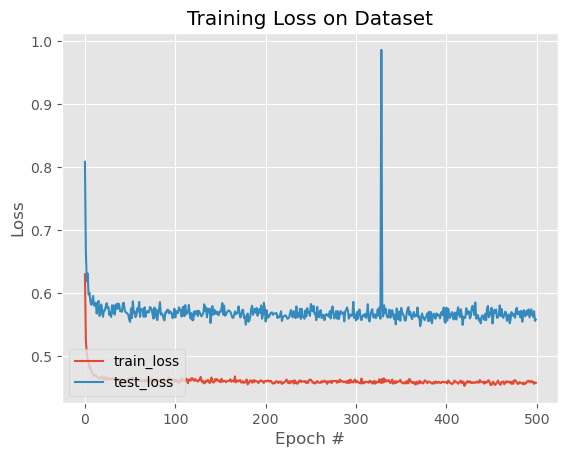

In [21]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(num_epochs)):
    # set the model in training mode
    unet.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalTestLoss = 0
    # loop over the training set
    for (i, (x, y)) in enumerate(trainLoader):
        # send the input to the device
        (x, y) = (x.to(device), y.to(device))
        # perform a forward pass and calculate the training loss
        pred = unet(x)
        loss = lossFunc(pred, y)
        # first, zero out any previously accumulated gradients, then
        # perform backpropagation, and then update model parameters
        opt.zero_grad()
        loss.backward()
        opt.step()
        # add the loss to the total training loss so far
        totalTrainLoss += loss
    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        unet.eval()
        # loop over the validation set
        for (x, y) in testLoader:
            # send the input to the device
            (x, y) = (x.to(device), y.to(device))
            # make the predictions and calculate the validation loss
            pred = unet(x)
            totalTestLoss += lossFunc(pred, y)
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps
    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, num_epochs))
    print("Train loss: {:.6f}, Test loss: {:.4f}".format(
        avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
    endTime - startTime))
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(plot_path)
# serialize the model to disk
torch.save(unet, model_path)

In [22]:
def prepare_plot(original_image: np.ndarray, original_mask: np.ndarray, predicted_mask: np.ndarray) -> None:
    """Prepares a plot with three subplots showing the original image, the ground truth mask, and the predicted mask."""
    # Calculate the 1st and 99th percentiles of the original and predicted masks
    original_q1, original_q99 = np.percentile(original_mask, (1, 99))
    predicted_q1, predicted_q99 = np.percentile(predicted_mask, (1, 99))
    original_min, original_max = original_mask.min(), original_mask.max() 
    predicted_min, predicted_max = predicted_mask.min(), predicted_mask.max() 
    print(f"Original mask range: {original_min:.4f} - {original_max:.4f}")
    print(f"Original mask 1st and 99th percentiles: {original_q1:.4f} - {original_q99:.4f}")
    print(f"Predicted mask range: {predicted_min:.4f} - {predicted_max:.4f}")
    print(f"Predicted mask 1st and 99th percentiles: {predicted_q1:.4f} - {predicted_q99:.4f}")
    
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))
    axes[0].imshow(original_image)
    axes[0].grid(False)
    axes[0].set_title("Image")
    axes[1].imshow(original_mask, cmap='gray', vmin=0, vmax=.45)
    axes[1].grid(False)
    axes[1].set_title("Original SEM")
    axes[2].imshow(predicted_mask, cmap='gray', vmin=0, vmax=.45)
    axes[2].grid(False)
    axes[2].set_title("Predicted SEM")
    axes[3].hist(original_mask.flatten(), bins=20, range=(0, .45), label='original', histtype='step')
    axes[3].hist(predicted_mask.flatten(), bins=20, range=(0, .45), label='prediction', histtype='step')
    axes[3].legend(loc='upper left')
    axes[3].grid(False)
    fig.tight_layout()
    plt.show()


def make_predictions(model: torch.nn.Module, image_path: str) -> None:
    """Takes a trained model and an image file path and generates a predicted mask."""
    model.eval()

    with torch.no_grad():
        
        # Load image and ground truth mask
        img_1 = np.array(Image.open(image_path).convert("RGB"), dtype=np.float32) / 255.0
        img_2_path = image_path.replace("PPL", "XPL")
        img_2 = np.array(Image.open(img_2_path).convert("RGB"), dtype=np.float32) / 255.0
        image = np.concatenate((img_1, img_2), axis=-1)
        original = image.copy()

        filename = os.path.split(image_path)[-1]
        ground_truth_path = os.path.join(mask_dataset_path, filename) 
        ground_truth_mask = np.array(Image.open(ground_truth_path).convert("L"), dtype=np.float32) / 255.0

        # Prepare input for model
        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).to(device)

        # Generate predicted mask
        predicted_mask = model(image).squeeze()
        predicted_mask = torch.sigmoid(predicted_mask)
        predicted_mask = predicted_mask.cpu().numpy()
        
        # Visualize results
        prepare_plot(original[:,:,0:3], ground_truth_mask, predicted_mask)

In [23]:
# load the image paths in our testing file and randomly select 10 image paths
print("[INFO] loading up test image paths...")
imagePaths = open(test_paths).read().strip().split("\n")
imagePaths = np.random.choice(imagePaths, size=10)

[INFO] loading up test image paths...


In [24]:
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(model_path).to(device)

[INFO] load up model...


Original mask range: 0.0039 - 0.9216
Original mask 1st and 99th percentiles: 0.0627 - 0.3725
Predicted mask range: 0.0393 - 0.4981
Predicted mask 1st and 99th percentiles: 0.0861 - 0.2843


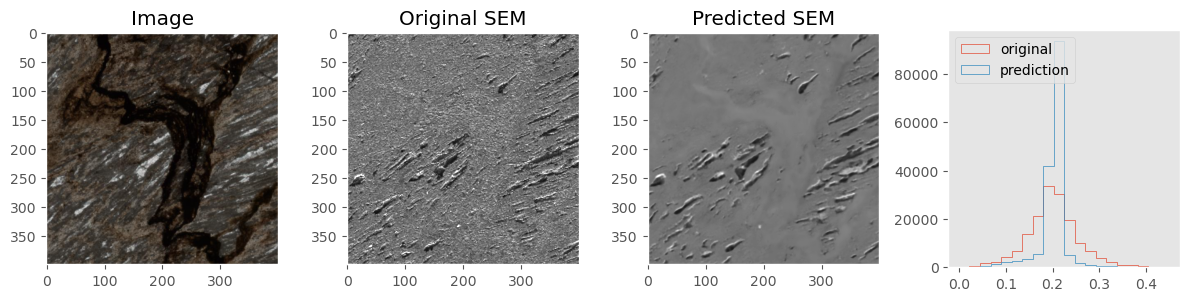

Original mask range: 0.0078 - 0.9647
Original mask 1st and 99th percentiles: 0.0745 - 0.4353
Predicted mask range: 0.0417 - 0.7153
Predicted mask 1st and 99th percentiles: 0.1017 - 0.3353


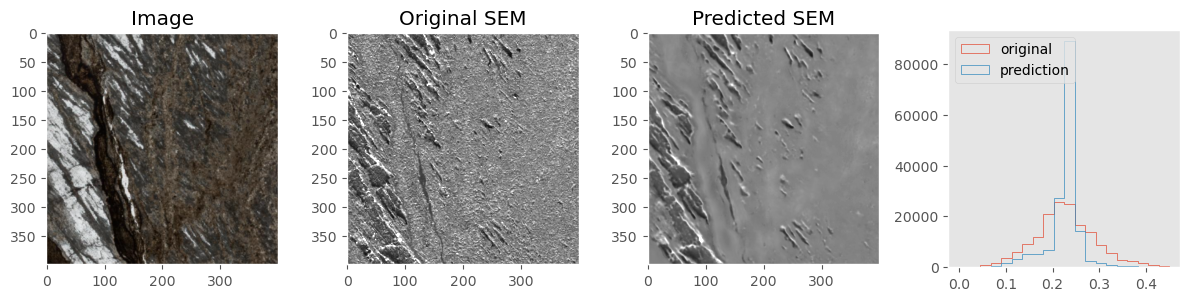

Original mask range: 0.0157 - 0.9529
Original mask 1st and 99th percentiles: 0.1020 - 0.4118
Predicted mask range: 0.0493 - 0.5320
Predicted mask 1st and 99th percentiles: 0.1485 - 0.2942


In [ ]:
# iterate over the randomly selected test image paths
for path in imagePaths:
    # make predictions and visualize the results
    make_predictions(unet, path)